In [1]:
from numpy import load
from numpy import zeros
from numpy import ones
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from matplotlib import pyplot

Using TensorFlow backend.


In [2]:
# load, split and scale the maps dataset ready for training
from os import listdir
from numpy import asarray
from numpy import vstack
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from numpy import savez_compressed

def load_images(path, size=(256,512)):
    src_list, tar_list = list(), list()
    # enumerate filenames in directory, assume all are images
    for filename in listdir(path):
        # load and resize the image
        pixels = load_img(path + filename, target_size=size)
        # convert to numpy array
        pixels = img_to_array(pixels)
        # split into satellite and map
        sat_img, map_img = pixels[:, :256], pixels[:, 256:]
        src_list.append(sat_img)
        tar_list.append(map_img)
    return [asarray(src_list), asarray(tar_list)]

In [3]:
# dataset path
path = 'maps/train/'
# path = 'E:\\shr0ud_kill3r\maps\train'
# load dataset
[src_images, tar_images] = load_images(path)
print('Loaded: ', src_images.shape, tar_images.shape)
# save as compressed numpy array
filename = 'maps_256.npz'
savez_compressed(filename, src_images, tar_images)
print('Saved dataset: ', filename)

Loaded:  (1096, 256, 256, 3) (1096, 256, 256, 3)
Saved dataset:  maps_256.npz


Loaded:  (1096, 256, 256, 3) (1096, 256, 256, 3)


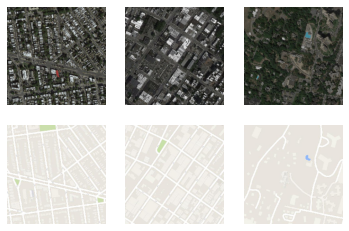

In [4]:
# load the prepared dataset
from numpy import load
from matplotlib import pyplot
# load the dataset
data = load('maps_256.npz')
src_images, tar_images = data['arr_0'], data['arr_1']
print('Loaded: ', src_images.shape, tar_images.shape)
# plot source images
n_samples = 3
for i in range(n_samples):
    pyplot.subplot(2, n_samples, 1 + i)
    pyplot.axis('off')
    pyplot.imshow(src_images[i].astype('uint8'))
# plot target image
for i in range(n_samples):
    pyplot.subplot(2, n_samples, 1 + n_samples + i)
    pyplot.axis('off')
    pyplot.imshow(tar_images[i].astype('uint8'))
pyplot.show()

In [5]:
# define the discriminator model
def define_discriminator(image_shape):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# source image input
	in_src_image = Input(shape=image_shape)
	# target image input
	in_target_image = Input(shape=image_shape)
	# concatenate images channel-wise
	merged = Concatenate()([in_src_image, in_target_image])
	# C64
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
	d = LeakyReLU(alpha=0.2)(d)
	# C128
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	patch_out = Activation('sigmoid')(d)
	# define model
	model = Model([in_src_image, in_target_image], patch_out)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
	return model

In [6]:
# define an encoder block
def define_encoder_block(layer_in, n_filters, batchnorm=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add downsampling layer
	g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# conditionally add batch normalization
	if batchnorm:
		g = BatchNormalization()(g, training=True)
	# leaky relu activation
	g = LeakyReLU(alpha=0.2)(g)
	return g

# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add upsampling layer
	g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# add batch normalization
	g = BatchNormalization()(g, training=True)
	# conditionally add dropout
	if dropout:
		g = Dropout(0.5)(g, training=True)
	# merge with skip connection
	g = Concatenate()([g, skip_in])
	# relu activation
	g = Activation('relu')(g)
	return g

# define the standalone generator model
def define_generator(image_shape=(256,256,3)):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)
	# encoder model
	e1 = define_encoder_block(in_image, 64, batchnorm=False)
	e2 = define_encoder_block(e1, 128)
	e3 = define_encoder_block(e2, 256)
	e4 = define_encoder_block(e3, 512)
	e5 = define_encoder_block(e4, 512)
	e6 = define_encoder_block(e5, 512)
	e7 = define_encoder_block(e6, 512)
	# bottleneck, no batch norm and relu
	b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
	b = Activation('relu')(b)
	# decoder model
	d1 = decoder_block(b, e7, 512)
	d2 = decoder_block(d1, e6, 512)
	d3 = decoder_block(d2, e5, 512)
	d4 = decoder_block(d3, e4, 512, dropout=False)
	d5 = decoder_block(d4, e3, 256, dropout=False)
	d6 = decoder_block(d5, e2, 128, dropout=False)
	d7 = decoder_block(d6, e1, 64, dropout=False)
	# output
	g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
	out_image = Activation('tanh')(g)
	# define model
	model = Model(in_image, out_image)
	return model

In [7]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, image_shape):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# define the source image
	in_src = Input(shape=image_shape)
	# connect the source image to the generator input
	gen_out = g_model(in_src)
	# connect the source input and generator output to the discriminator input
	dis_out = d_model([in_src, gen_out])
	# src image as input, generated image and classification output
	model = Model(in_src, [dis_out, gen_out])
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
	return model

In [8]:
# load and prepare training images
def load_real_samples(filename):
	# load compressed arrays
	data = load(filename)
	# unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

In [9]:
# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
	# unpack dataset
	trainA, trainB = dataset
	# choose random instances
	ix = randint(0, trainA.shape[0], n_samples)
	# retrieve selected images
	X1, X2 = trainA[ix], trainB[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return [X1, X2], y

In [10]:
# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
	# generate fake instance
	X = g_model.predict(samples)
	# create 'fake' class labels (0)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

In [11]:
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, dataset, n_samples=3):
	# select a sample of input images
	[X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
	# generate a batch of fake samples
	X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
	# scale all pixels from [-1,1] to [0,1]
	X_realA = (X_realA + 1) / 2.0
	X_realB = (X_realB + 1) / 2.0
	X_fakeB = (X_fakeB + 1) / 2.0
	# plot real source images
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(X_realA[i])
	# plot generated target image
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + n_samples + i)
		pyplot.axis('off')
		pyplot.imshow(X_fakeB[i])
	# plot real target image
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + n_samples*2 + i)
		pyplot.axis('off')
		pyplot.imshow(X_realB[i])
	# save plot to file
	filename1 = 'plot_%06d.png' % (step+1)
	pyplot.savefig(filename1)
	pyplot.close()
	# save the generator model
	filename2 = 'model_%06d.h5' % (step+1)
	g_model.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))

In [13]:
# train pix2pix model
def train(d_model, g_model, gan_model, dataset, n_epochs=50, n_batch=1):
	# determine the output square shape of the discriminator
	n_patch = d_model.output_shape[1]
	# unpack dataset
	trainA, trainB = dataset
	# calculate the number of batches per training epoch
	bat_per_epo = int(len(trainA) / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# manually enumerate epochs
	for i in range(n_steps):
		# select a batch of real samples
		[X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
		# generate a batch of fake samples
		X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
		# update discriminator for real samples
		d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
		# update discriminator for generated samples
		d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
		# update the generator
		g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
		# summarize performance
		print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
		# summarize model performance
		if (i+1) % (bat_per_epo * 10) == 0:
			summarize_performance(i, g_model, dataset)

In [14]:
# load image data
dataset = load_real_samples('maps_256.npz')
print('Loaded', dataset[0].shape, dataset[1].shape)
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
# define the models
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)
# define the composite model
gan_model = define_gan(g_model, d_model, image_shape)
# train model
train(d_model, g_model, gan_model, dataset)

Loaded (1096, 256, 256, 3) (1096, 256, 256, 3)


D:\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
D:\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>1, d1[0.289] d2[0.872] g[84.308]


D:\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>2, d1[0.225] d2[0.670] g[83.306]
>3, d1[0.331] d2[0.563] g[57.386]
>4, d1[0.483] d2[0.707] g[68.718]
>5, d1[0.380] d2[0.507] g[66.078]
>6, d1[0.366] d2[0.451] g[46.127]
>7, d1[0.278] d2[0.401] g[66.429]
>8, d1[0.287] d2[0.354] g[66.222]
>9, d1[0.204] d2[0.325] g[64.041]
>10, d1[0.162] d2[0.466] g[51.958]
>11, d1[0.302] d2[0.526] g[50.862]
>12, d1[0.255] d2[1.474] g[44.089]
>13, d1[0.260] d2[0.187] g[53.105]
>14, d1[0.493] d2[0.380] g[24.366]
>15, d1[0.116] d2[0.154] g[47.375]
>16, d1[0.143] d2[0.146] g[46.119]
>17, d1[0.102] d2[0.140] g[45.269]
>18, d1[0.213] d2[0.294] g[33.440]
>19, d1[0.044] d2[0.080] g[39.903]
>20, d1[0.112] d2[0.106] g[39.944]
>21, d1[0.107] d2[0.113] g[36.881]
>22, d1[0.230] d2[0.680] g[28.333]
>23, d1[0.323] d2[0.086] g[33.595]
>24, d1[0.134] d2[0.107] g[31.555]
>25, d1[0.079] d2[0.152] g[27.687]
>26, d1[0.138] d2[0.167] g[25.190]
>27, d1[0.624] d2[1.835] g[21.469]
>28, d1[0.044] d2[0.896] g[21.475]
>29, d1[0.305] d2[0.361] g[19.676]
>30, d1[0.443] d2[0.291] g[2

>234, d1[0.208] d2[0.111] g[13.673]
>235, d1[0.065] d2[0.070] g[24.234]
>236, d1[0.754] d2[0.214] g[9.606]
>237, d1[0.016] d2[0.189] g[13.265]
>238, d1[0.433] d2[0.359] g[9.655]
>239, d1[0.049] d2[0.142] g[19.269]
>240, d1[0.055] d2[0.092] g[13.217]
>241, d1[0.052] d2[0.074] g[22.904]
>242, d1[0.029] d2[0.104] g[29.546]
>243, d1[0.092] d2[0.109] g[18.386]
>244, d1[0.113] d2[0.426] g[21.426]
>245, d1[0.120] d2[0.043] g[18.679]
>246, d1[0.440] d2[0.086] g[19.279]
>247, d1[0.988] d2[0.573] g[14.532]
>248, d1[0.968] d2[0.448] g[17.319]
>249, d1[0.392] d2[0.380] g[10.228]
>250, d1[0.380] d2[0.236] g[11.286]
>251, d1[0.276] d2[0.285] g[10.000]
>252, d1[0.023] d2[0.281] g[17.107]
>253, d1[0.831] d2[0.192] g[20.161]
>254, d1[0.355] d2[0.228] g[10.201]
>255, d1[0.327] d2[0.382] g[8.663]
>256, d1[0.121] d2[0.323] g[10.354]
>257, d1[0.263] d2[0.308] g[8.675]
>258, d1[0.021] d2[0.117] g[13.967]
>259, d1[0.460] d2[0.218] g[8.792]
>260, d1[0.215] d2[0.151] g[20.916]
>261, d1[0.252] d2[0.299] g[9.050

>463, d1[0.012] d2[0.127] g[17.152]
>464, d1[0.201] d2[0.240] g[9.117]
>465, d1[0.146] d2[0.075] g[11.556]
>466, d1[0.030] d2[0.083] g[15.366]
>467, d1[0.303] d2[0.108] g[11.180]
>468, d1[0.042] d2[0.100] g[17.353]
>469, d1[0.009] d2[0.089] g[13.760]
>470, d1[0.023] d2[0.060] g[14.739]
>471, d1[0.019] d2[0.257] g[19.113]
>472, d1[0.478] d2[0.046] g[11.142]
>473, d1[0.502] d2[0.087] g[17.579]
>474, d1[0.067] d2[0.242] g[9.054]
>475, d1[0.618] d2[0.154] g[10.138]
>476, d1[0.036] d2[0.430] g[9.443]
>477, d1[0.181] d2[0.085] g[11.500]
>478, d1[0.381] d2[0.292] g[8.182]
>479, d1[0.004] d2[0.256] g[21.461]
>480, d1[0.007] d2[0.052] g[14.353]
>481, d1[0.212] d2[0.133] g[14.090]
>482, d1[0.151] d2[0.190] g[9.773]
>483, d1[0.054] d2[0.214] g[10.910]
>484, d1[0.157] d2[0.161] g[10.009]
>485, d1[0.022] d2[0.075] g[12.827]
>486, d1[0.430] d2[0.283] g[11.529]
>487, d1[1.494] d2[0.253] g[16.946]
>488, d1[0.009] d2[0.114] g[22.486]
>489, d1[0.317] d2[0.219] g[9.401]
>490, d1[0.010] d2[0.176] g[13.533

>692, d1[0.208] d2[0.040] g[12.262]
>693, d1[0.327] d2[0.085] g[13.446]
>694, d1[0.036] d2[0.096] g[15.502]
>695, d1[0.072] d2[0.073] g[15.514]
>696, d1[0.684] d2[0.118] g[17.015]
>697, d1[0.411] d2[0.444] g[12.571]
>698, d1[0.150] d2[0.322] g[17.405]
>699, d1[0.143] d2[0.309] g[10.965]
>700, d1[0.042] d2[0.153] g[12.176]
>701, d1[0.352] d2[0.054] g[15.794]
>702, d1[0.134] d2[0.080] g[12.724]
>703, d1[0.408] d2[0.073] g[22.388]
>704, d1[0.095] d2[0.355] g[9.667]
>705, d1[0.048] d2[0.184] g[10.131]
>706, d1[0.344] d2[0.105] g[14.676]
>707, d1[0.122] d2[0.193] g[9.998]
>708, d1[0.272] d2[0.229] g[10.259]
>709, d1[0.002] d2[0.127] g[18.613]
>710, d1[0.107] d2[0.070] g[12.094]
>711, d1[0.175] d2[0.207] g[9.647]
>712, d1[0.016] d2[0.481] g[22.858]
>713, d1[0.021] d2[0.020] g[21.975]
>714, d1[0.617] d2[0.092] g[15.230]
>715, d1[0.054] d2[0.120] g[20.567]
>716, d1[0.009] d2[0.110] g[22.625]
>717, d1[0.955] d2[0.289] g[13.071]
>718, d1[0.133] d2[0.141] g[11.613]
>719, d1[0.772] d2[1.219] g[24.

>921, d1[0.769] d2[0.127] g[13.469]
>922, d1[0.005] d2[0.608] g[10.444]
>923, d1[0.301] d2[0.048] g[17.806]
>924, d1[0.113] d2[0.047] g[16.341]
>925, d1[0.149] d2[0.414] g[8.867]
>926, d1[0.217] d2[0.131] g[9.447]
>927, d1[0.192] d2[0.199] g[9.692]
>928, d1[0.051] d2[0.023] g[14.891]
>929, d1[0.098] d2[0.482] g[8.866]
>930, d1[0.004] d2[0.042] g[13.992]
>931, d1[0.004] d2[0.026] g[15.103]
>932, d1[0.681] d2[0.180] g[8.303]
>933, d1[0.002] d2[0.122] g[13.151]
>934, d1[0.328] d2[0.210] g[16.010]
>935, d1[0.142] d2[0.176] g[9.083]
>936, d1[0.343] d2[0.089] g[8.951]
>937, d1[0.161] d2[0.554] g[17.603]
>938, d1[0.153] d2[0.055] g[13.255]
>939, d1[0.167] d2[0.269] g[10.924]
>940, d1[0.301] d2[0.048] g[15.458]
>941, d1[0.478] d2[0.866] g[9.840]
>942, d1[0.253] d2[0.070] g[9.811]
>943, d1[0.272] d2[0.139] g[20.479]
>944, d1[0.136] d2[0.249] g[9.051]
>945, d1[0.018] d2[0.240] g[18.367]
>946, d1[0.131] d2[0.564] g[15.430]
>947, d1[1.256] d2[0.056] g[10.818]
>948, d1[0.004] d2[0.308] g[13.434]
>9

>1147, d1[0.009] d2[0.153] g[14.636]
>1148, d1[0.565] d2[0.251] g[9.607]
>1149, d1[0.003] d2[0.069] g[14.059]
>1150, d1[0.317] d2[0.224] g[8.662]
>1151, d1[0.231] d2[0.169] g[9.989]
>1152, d1[0.067] d2[0.645] g[15.792]
>1153, d1[0.652] d2[0.230] g[9.121]
>1154, d1[0.003] d2[0.080] g[14.166]
>1155, d1[0.005] d2[0.041] g[16.244]
>1156, d1[0.389] d2[0.232] g[9.823]
>1157, d1[0.069] d2[0.231] g[10.840]
>1158, d1[0.171] d2[0.182] g[9.806]
>1159, d1[0.569] d2[0.070] g[14.666]
>1160, d1[0.145] d2[0.130] g[14.411]
>1161, d1[0.002] d2[0.189] g[29.858]
>1162, d1[0.388] d2[0.737] g[14.019]
>1163, d1[0.096] d2[0.174] g[15.415]
>1164, d1[0.617] d2[0.185] g[10.498]
>1165, d1[0.034] d2[0.292] g[12.800]
>1166, d1[0.199] d2[0.074] g[10.230]
>1167, d1[0.125] d2[0.113] g[17.147]
>1168, d1[0.020] d2[0.067] g[15.933]
>1169, d1[0.127] d2[0.125] g[11.735]
>1170, d1[0.155] d2[0.236] g[18.969]
>1171, d1[0.017] d2[0.080] g[15.476]
>1172, d1[0.153] d2[0.034] g[13.562]
>1173, d1[0.990] d2[0.726] g[12.770]
>1174, 

>1370, d1[0.029] d2[0.025] g[12.702]
>1371, d1[0.377] d2[0.219] g[16.169]
>1372, d1[0.018] d2[0.034] g[23.961]
>1373, d1[0.060] d2[0.017] g[14.916]
>1374, d1[0.174] d2[0.217] g[15.751]
>1375, d1[0.928] d2[0.269] g[14.888]
>1376, d1[1.211] d2[0.444] g[9.809]
>1377, d1[0.143] d2[0.206] g[10.387]
>1378, d1[0.002] d2[0.113] g[16.344]
>1379, d1[0.004] d2[0.054] g[13.310]
>1380, d1[0.018] d2[0.037] g[20.966]
>1381, d1[0.431] d2[0.050] g[11.079]
>1382, d1[0.018] d2[0.399] g[12.339]
>1383, d1[0.024] d2[0.179] g[14.623]
>1384, d1[0.003] d2[0.089] g[15.903]
>1385, d1[0.478] d2[0.126] g[9.030]
>1386, d1[0.329] d2[0.283] g[9.658]
>1387, d1[0.168] d2[0.627] g[8.207]
>1388, d1[0.014] d2[0.073] g[10.333]
>1389, d1[0.123] d2[0.007] g[21.771]
>1390, d1[1.022] d2[0.171] g[13.310]
>1391, d1[0.289] d2[0.156] g[8.766]
>1392, d1[0.004] d2[0.113] g[12.275]
>1393, d1[0.017] d2[1.143] g[12.237]
>1394, d1[0.333] d2[0.026] g[10.835]
>1395, d1[1.372] d2[0.582] g[9.470]
>1396, d1[0.082] d2[0.287] g[15.077]
>1397, 

>1593, d1[0.198] d2[0.140] g[19.023]
>1594, d1[0.014] d2[0.027] g[12.574]
>1595, d1[0.269] d2[0.124] g[9.512]
>1596, d1[0.129] d2[0.185] g[17.058]
>1597, d1[0.485] d2[0.161] g[12.812]
>1598, d1[0.330] d2[0.391] g[21.879]
>1599, d1[0.752] d2[0.522] g[10.423]
>1600, d1[0.477] d2[0.273] g[11.133]
>1601, d1[0.445] d2[0.329] g[10.284]
>1602, d1[0.001] d2[0.029] g[15.130]
>1603, d1[0.603] d2[0.294] g[8.367]
>1604, d1[0.058] d2[0.270] g[9.368]
>1605, d1[0.003] d2[0.241] g[21.437]
>1606, d1[0.051] d2[0.037] g[15.155]
>1607, d1[0.528] d2[0.111] g[17.570]
>1608, d1[0.008] d2[0.334] g[19.246]
>1609, d1[0.618] d2[0.231] g[12.977]
>1610, d1[0.144] d2[0.104] g[9.176]
>1611, d1[0.010] d2[0.129] g[18.398]
>1612, d1[0.037] d2[0.069] g[15.484]
>1613, d1[0.024] d2[0.125] g[10.818]
>1614, d1[0.004] d2[0.013] g[20.356]
>1615, d1[0.983] d2[1.168] g[8.062]
>1616, d1[0.011] d2[0.055] g[14.423]
>1617, d1[0.053] d2[0.233] g[16.868]
>1618, d1[0.875] d2[0.318] g[10.337]
>1619, d1[0.026] d2[0.044] g[13.777]
>1620,

>1816, d1[0.021] d2[0.043] g[16.467]
>1817, d1[1.197] d2[0.115] g[10.164]
>1818, d1[0.006] d2[0.554] g[10.858]
>1819, d1[0.006] d2[0.033] g[11.652]
>1820, d1[0.082] d2[0.037] g[11.910]
>1821, d1[0.668] d2[0.114] g[9.477]
>1822, d1[0.001] d2[0.225] g[13.725]
>1823, d1[1.544] d2[0.167] g[21.023]
>1824, d1[0.001] d2[0.453] g[23.113]
>1825, d1[0.100] d2[0.208] g[8.309]
>1826, d1[0.779] d2[0.117] g[10.826]
>1827, d1[0.054] d2[0.126] g[8.783]
>1828, d1[0.001] d2[0.053] g[13.242]
>1829, d1[0.230] d2[0.168] g[14.703]
>1830, d1[0.166] d2[0.164] g[9.550]
>1831, d1[0.367] d2[0.370] g[7.702]
>1832, d1[0.000] d2[0.119] g[12.266]
>1833, d1[0.159] d2[0.096] g[9.900]
>1834, d1[0.204] d2[0.124] g[8.782]
>1835, d1[0.037] d2[0.190] g[20.267]
>1836, d1[0.378] d2[0.208] g[10.250]
>1837, d1[0.001] d2[0.126] g[13.442]
>1838, d1[0.003] d2[0.200] g[10.002]
>1839, d1[0.709] d2[0.248] g[7.393]
>1840, d1[0.004] d2[0.089] g[14.942]
>1841, d1[0.271] d2[0.273] g[9.217]
>1842, d1[0.150] d2[0.153] g[11.624]
>1843, d1[

>2040, d1[0.202] d2[0.130] g[12.293]
>2041, d1[0.002] d2[0.275] g[16.107]
>2042, d1[0.012] d2[0.015] g[15.640]
>2043, d1[0.002] d2[0.013] g[19.840]
>2044, d1[0.595] d2[0.231] g[20.045]
>2045, d1[0.115] d2[0.235] g[15.518]
>2046, d1[0.001] d2[0.023] g[18.235]
>2047, d1[0.037] d2[0.023] g[16.279]
>2048, d1[0.436] d2[0.117] g[9.859]
>2049, d1[0.001] d2[0.335] g[14.760]
>2050, d1[0.536] d2[0.100] g[10.552]
>2051, d1[0.145] d2[0.741] g[13.643]
>2052, d1[0.879] d2[0.189] g[8.492]
>2053, d1[0.261] d2[0.263] g[8.870]
>2054, d1[0.050] d2[0.110] g[15.701]
>2055, d1[0.061] d2[0.084] g[12.571]
>2056, d1[0.637] d2[0.289] g[9.551]
>2057, d1[0.033] d2[0.162] g[11.097]
>2058, d1[0.007] d2[0.037] g[10.508]
>2059, d1[0.547] d2[0.235] g[8.032]
>2060, d1[0.036] d2[0.155] g[15.236]
>2061, d1[0.000] d2[0.093] g[12.389]
>2062, d1[0.002] d2[0.054] g[13.400]
>2063, d1[0.051] d2[0.064] g[12.105]
>2064, d1[0.030] d2[0.064] g[14.061]
>2065, d1[0.162] d2[0.031] g[13.014]
>2066, d1[0.023] d2[0.044] g[18.383]
>2067,

>2263, d1[0.017] d2[0.052] g[12.630]
>2264, d1[0.341] d2[0.205] g[10.967]
>2265, d1[0.000] d2[0.068] g[15.388]
>2266, d1[0.004] d2[0.018] g[22.375]
>2267, d1[0.086] d2[0.066] g[8.954]
>2268, d1[0.009] d2[0.016] g[17.208]
>2269, d1[0.698] d2[0.464] g[9.912]
>2270, d1[0.003] d2[0.073] g[10.457]
>2271, d1[0.331] d2[0.196] g[12.021]
>2272, d1[0.176] d2[0.169] g[10.029]
>2273, d1[0.302] d2[0.521] g[10.301]
>2274, d1[0.288] d2[0.091] g[8.848]
>2275, d1[0.503] d2[0.517] g[10.428]
>2276, d1[0.003] d2[0.032] g[16.532]
>2277, d1[0.022] d2[0.053] g[15.561]
>2278, d1[0.688] d2[1.036] g[9.927]
>2279, d1[0.062] d2[0.037] g[17.988]
>2280, d1[0.129] d2[0.105] g[9.542]
>2281, d1[0.010] d2[0.023] g[11.260]
>2282, d1[0.010] d2[0.103] g[10.348]
>2283, d1[0.615] d2[0.296] g[7.799]
>2284, d1[0.187] d2[0.103] g[22.448]
>2285, d1[0.190] d2[0.531] g[8.909]
>2286, d1[0.167] d2[0.333] g[9.910]
>2287, d1[0.003] d2[0.102] g[19.033]
>2288, d1[0.639] d2[0.102] g[10.609]
>2289, d1[0.182] d2[0.298] g[12.824]
>2290, d1

>2487, d1[0.343] d2[0.081] g[9.928]
>2488, d1[0.001] d2[0.932] g[15.689]
>2489, d1[0.112] d2[0.081] g[15.016]
>2490, d1[0.305] d2[0.050] g[11.369]
>2491, d1[0.121] d2[0.052] g[14.600]
>2492, d1[0.242] d2[0.247] g[9.758]
>2493, d1[0.267] d2[0.561] g[9.960]
>2494, d1[0.001] d2[0.049] g[15.546]
>2495, d1[0.072] d2[0.035] g[11.254]
>2496, d1[0.200] d2[0.267] g[21.650]
>2497, d1[0.947] d2[0.219] g[9.114]
>2498, d1[0.007] d2[0.045] g[13.939]
>2499, d1[0.075] d2[0.516] g[14.217]
>2500, d1[0.410] d2[0.080] g[8.485]
>2501, d1[0.008] d2[0.360] g[14.755]
>2502, d1[0.013] d2[0.008] g[13.123]
>2503, d1[0.088] d2[0.035] g[13.583]
>2504, d1[0.810] d2[0.156] g[8.124]
>2505, d1[0.057] d2[0.156] g[14.203]
>2506, d1[0.006] d2[0.205] g[17.084]
>2507, d1[0.279] d2[0.145] g[10.753]
>2508, d1[0.812] d2[0.228] g[10.385]
>2509, d1[0.144] d2[0.181] g[12.906]
>2510, d1[0.020] d2[0.054] g[9.948]
>2511, d1[0.001] d2[0.161] g[11.861]
>2512, d1[0.309] d2[0.219] g[8.224]
>2513, d1[0.007] d2[0.058] g[13.990]
>2514, d1

>2711, d1[0.327] d2[0.180] g[8.381]
>2712, d1[0.040] d2[0.250] g[8.282]
>2713, d1[0.007] d2[0.008] g[17.187]
>2714, d1[0.002] d2[0.032] g[15.246]
>2715, d1[0.329] d2[0.134] g[7.959]
>2716, d1[0.079] d2[0.181] g[8.597]
>2717, d1[0.157] d2[0.075] g[9.995]
>2718, d1[0.000] d2[0.199] g[11.291]
>2719, d1[0.000] d2[0.080] g[14.003]
>2720, d1[0.151] d2[0.108] g[9.480]
>2721, d1[0.001] d2[0.061] g[11.493]
>2722, d1[0.005] d2[0.021] g[13.719]
>2723, d1[0.013] d2[0.020] g[19.776]
>2724, d1[0.648] d2[0.101] g[7.511]
>2725, d1[0.095] d2[0.226] g[8.589]
>2726, d1[0.053] d2[0.314] g[9.062]
>2727, d1[0.204] d2[0.077] g[11.133]
>2728, d1[0.165] d2[0.417] g[9.913]
>2729, d1[0.359] d2[0.070] g[17.040]
>2730, d1[0.000] d2[0.052] g[14.307]
>2731, d1[0.001] d2[0.016] g[21.262]
>2732, d1[0.565] d2[0.283] g[9.516]
>2733, d1[0.193] d2[0.244] g[8.852]
>2734, d1[0.001] d2[0.092] g[11.329]
>2735, d1[0.500] d2[0.160] g[10.156]
>2736, d1[0.001] d2[0.130] g[14.596]
>2737, d1[0.767] d2[0.489] g[9.676]
>2738, d1[0.11

>2935, d1[0.360] d2[0.199] g[9.075]
>2936, d1[0.390] d2[0.222] g[8.300]
>2937, d1[0.002] d2[0.212] g[13.079]
>2938, d1[0.003] d2[0.048] g[12.322]
>2939, d1[0.048] d2[0.060] g[9.616]
>2940, d1[0.749] d2[0.190] g[12.407]
>2941, d1[0.006] d2[0.023] g[12.893]
>2942, d1[0.161] d2[0.539] g[12.749]
>2943, d1[0.027] d2[0.020] g[16.433]
>2944, d1[0.408] d2[0.388] g[10.850]
>2945, d1[0.011] d2[0.025] g[9.416]
>2946, d1[0.522] d2[0.143] g[9.007]
>2947, d1[0.168] d2[0.046] g[14.386]
>2948, d1[0.007] d2[0.157] g[14.950]
>2949, d1[0.051] d2[0.120] g[9.803]
>2950, d1[0.065] d2[0.238] g[9.326]
>2951, d1[0.027] d2[0.052] g[9.194]
>2952, d1[0.005] d2[0.021] g[9.258]
>2953, d1[0.015] d2[0.032] g[15.003]
>2954, d1[0.571] d2[0.087] g[9.918]
>2955, d1[0.028] d2[0.439] g[11.771]
>2956, d1[0.027] d2[0.056] g[13.851]
>2957, d1[0.934] d2[0.103] g[9.479]
>2958, d1[0.323] d2[0.097] g[19.332]
>2959, d1[0.015] d2[0.482] g[9.722]
>2960, d1[0.008] d2[0.070] g[13.362]
>2961, d1[0.376] d2[0.183] g[9.288]
>2962, d1[0.05

>3159, d1[0.004] d2[0.049] g[22.078]
>3160, d1[0.002] d2[0.063] g[13.966]
>3161, d1[0.031] d2[0.009] g[11.397]
>3162, d1[0.812] d2[0.403] g[13.112]
>3163, d1[0.262] d2[0.123] g[9.807]
>3164, d1[0.134] d2[0.209] g[14.179]
>3165, d1[0.002] d2[0.054] g[17.502]
>3166, d1[0.665] d2[0.486] g[7.790]
>3167, d1[0.027] d2[0.550] g[12.108]
>3168, d1[0.034] d2[0.004] g[12.156]
>3169, d1[0.008] d2[0.061] g[13.547]
>3170, d1[0.099] d2[0.015] g[14.545]
>3171, d1[0.695] d2[0.237] g[11.348]
>3172, d1[0.326] d2[0.086] g[8.333]
>3173, d1[0.101] d2[0.240] g[8.998]
>3174, d1[0.063] d2[0.137] g[9.445]
>3175, d1[0.036] d2[0.081] g[15.626]
>3176, d1[0.021] d2[0.054] g[15.150]
>3177, d1[0.001] d2[0.034] g[22.075]
>3178, d1[0.191] d2[0.669] g[10.309]
>3179, d1[0.469] d2[0.113] g[13.252]
>3180, d1[0.641] d2[0.665] g[7.520]
>3181, d1[0.011] d2[0.128] g[12.682]
>3182, d1[0.198] d2[0.110] g[11.936]
>3183, d1[0.001] d2[0.028] g[15.042]
>3184, d1[0.324] d2[0.568] g[13.442]
>3185, d1[0.488] d2[0.090] g[8.789]
>3186, d

>3383, d1[0.014] d2[0.075] g[18.964]
>3384, d1[0.001] d2[0.115] g[11.896]
>3385, d1[0.004] d2[0.019] g[19.345]
>3386, d1[0.015] d2[0.012] g[16.008]
>3387, d1[0.930] d2[0.223] g[8.722]
>3388, d1[0.336] d2[0.245] g[11.396]
>3389, d1[0.213] d2[0.138] g[11.727]
>3390, d1[0.010] d2[0.345] g[13.071]
>3391, d1[0.234] d2[0.034] g[17.060]
>3392, d1[1.128] d2[0.164] g[10.291]
>3393, d1[0.006] d2[0.063] g[13.730]
>3394, d1[0.007] d2[0.359] g[14.468]
>3395, d1[0.143] d2[0.064] g[15.023]
>3396, d1[0.316] d2[0.493] g[14.173]
>3397, d1[0.054] d2[0.164] g[10.850]
>3398, d1[0.267] d2[0.028] g[18.419]
>3399, d1[0.337] d2[0.123] g[9.284]
>3400, d1[0.018] d2[0.201] g[8.211]
>3401, d1[0.540] d2[0.284] g[11.517]
>3402, d1[0.014] d2[0.183] g[14.324]
>3403, d1[0.170] d2[0.148] g[10.095]
>3404, d1[0.015] d2[0.182] g[15.003]
>3405, d1[0.188] d2[0.325] g[11.572]
>3406, d1[0.267] d2[0.152] g[8.416]
>3407, d1[0.028] d2[0.023] g[14.633]
>3408, d1[0.214] d2[0.098] g[8.870]
>3409, d1[0.102] d2[0.141] g[11.920]
>3410,

>3607, d1[0.192] d2[0.258] g[10.635]
>3608, d1[0.026] d2[0.089] g[10.999]
>3609, d1[0.240] d2[0.168] g[9.132]
>3610, d1[0.008] d2[0.173] g[12.618]
>3611, d1[0.002] d2[0.049] g[18.950]
>3612, d1[0.008] d2[0.049] g[11.582]
>3613, d1[0.171] d2[0.226] g[11.443]
>3614, d1[0.335] d2[0.122] g[12.159]
>3615, d1[0.374] d2[0.502] g[8.597]
>3616, d1[0.163] d2[0.040] g[12.046]
>3617, d1[0.002] d2[0.078] g[22.045]
>3618, d1[0.281] d2[0.250] g[11.094]
>3619, d1[0.098] d2[0.462] g[13.497]
>3620, d1[0.023] d2[0.015] g[13.357]
>3621, d1[1.387] d2[0.079] g[11.508]
>3622, d1[0.089] d2[0.258] g[11.419]
>3623, d1[0.265] d2[0.503] g[9.076]
>3624, d1[0.008] d2[0.038] g[18.917]
>3625, d1[0.587] d2[0.130] g[7.694]
>3626, d1[0.093] d2[0.081] g[14.165]
>3627, d1[0.059] d2[0.700] g[7.745]
>3628, d1[0.017] d2[0.036] g[10.188]
>3629, d1[0.557] d2[0.373] g[9.096]
>3630, d1[0.037] d2[0.029] g[10.997]
>3631, d1[0.732] d2[0.107] g[8.459]
>3632, d1[0.006] d2[0.050] g[13.472]
>3633, d1[0.345] d2[0.218] g[7.277]
>3634, d1

>3831, d1[0.517] d2[0.083] g[8.181]
>3832, d1[0.314] d2[0.372] g[9.416]
>3833, d1[0.032] d2[0.014] g[20.621]
>3834, d1[1.013] d2[0.010] g[14.045]
>3835, d1[0.001] d2[0.188] g[13.426]
>3836, d1[0.005] d2[0.108] g[12.248]
>3837, d1[0.004] d2[0.132] g[11.426]
>3838, d1[1.122] d2[0.264] g[7.491]
>3839, d1[0.004] d2[0.061] g[13.622]
>3840, d1[0.314] d2[0.215] g[9.996]
>3841, d1[0.089] d2[0.281] g[12.921]
>3842, d1[0.013] d2[0.230] g[18.819]
>3843, d1[0.002] d2[0.041] g[18.104]
>3844, d1[0.221] d2[1.076] g[16.856]
>3845, d1[1.503] d2[0.034] g[9.496]
>3846, d1[0.019] d2[0.074] g[10.502]
>3847, d1[1.132] d2[0.286] g[7.462]
>3848, d1[0.372] d2[0.029] g[22.252]
>3849, d1[0.074] d2[0.232] g[12.062]
>3850, d1[0.052] d2[0.157] g[10.037]
>3851, d1[0.044] d2[0.173] g[13.733]
>3852, d1[0.250] d2[0.216] g[7.957]
>3853, d1[0.017] d2[0.090] g[11.225]
>3854, d1[0.398] d2[0.260] g[7.541]
>3855, d1[0.076] d2[0.228] g[9.973]
>3856, d1[0.100] d2[0.159] g[12.216]
>3857, d1[0.289] d2[0.127] g[9.399]
>3858, d1[0

>4055, d1[0.219] d2[0.104] g[14.740]
>4056, d1[0.001] d2[0.704] g[22.979]
>4057, d1[0.047] d2[0.020] g[12.300]
>4058, d1[0.054] d2[0.279] g[9.419]
>4059, d1[0.040] d2[0.010] g[24.036]
>4060, d1[0.205] d2[0.018] g[9.798]
>4061, d1[0.879] d2[0.391] g[8.814]
>4062, d1[0.249] d2[0.093] g[13.866]
>4063, d1[0.023] d2[0.327] g[12.073]
>4064, d1[0.292] d2[0.117] g[8.740]
>4065, d1[0.131] d2[0.317] g[8.785]
>4066, d1[0.143] d2[0.049] g[18.821]
>4067, d1[0.004] d2[0.028] g[22.300]
>4068, d1[0.833] d2[0.301] g[9.330]
>4069, d1[0.048] d2[0.100] g[17.698]
>4070, d1[0.053] d2[0.191] g[9.636]
>4071, d1[0.008] d2[0.065] g[16.319]
>4072, d1[0.023] d2[0.048] g[13.251]
>4073, d1[0.041] d2[0.027] g[11.934]
>4074, d1[0.094] d2[0.047] g[13.646]
>4075, d1[0.045] d2[0.018] g[19.063]
>4076, d1[0.165] d2[0.397] g[14.404]
>4077, d1[0.011] d2[0.015] g[15.788]
>4078, d1[0.002] d2[0.016] g[15.739]
>4079, d1[0.811] d2[0.446] g[9.816]
>4080, d1[0.299] d2[0.095] g[9.995]
>4081, d1[0.136] d2[0.096] g[10.061]
>4082, d1[

>4279, d1[0.520] d2[0.239] g[8.987]
>4280, d1[0.001] d2[0.166] g[16.400]
>4281, d1[0.035] d2[0.037] g[11.112]
>4282, d1[0.844] d2[0.437] g[9.228]
>4283, d1[0.016] d2[0.030] g[10.646]
>4284, d1[0.001] d2[0.018] g[9.170]
>4285, d1[0.055] d2[0.059] g[10.062]
>4286, d1[0.009] d2[0.019] g[12.328]
>4287, d1[0.004] d2[0.064] g[11.663]
>4288, d1[0.001] d2[0.005] g[23.728]
>4289, d1[0.000] d2[0.040] g[12.659]
>4290, d1[0.006] d2[0.005] g[16.346]
>4291, d1[0.018] d2[0.049] g[14.551]
>4292, d1[0.566] d2[0.506] g[10.291]
>4293, d1[0.013] d2[0.051] g[12.340]
>4294, d1[0.119] d2[0.021] g[11.882]
>4295, d1[0.001] d2[0.401] g[14.181]
>4296, d1[0.002] d2[0.006] g[16.795]
>4297, d1[0.179] d2[0.002] g[22.394]
>4298, d1[0.004] d2[0.023] g[23.210]
>4299, d1[0.562] d2[0.183] g[9.878]
>4300, d1[0.310] d2[0.489] g[13.794]
>4301, d1[0.079] d2[0.054] g[15.087]
>4302, d1[0.541] d2[0.050] g[10.278]
>4303, d1[0.001] d2[0.102] g[15.467]
>4304, d1[0.150] d2[0.073] g[9.476]
>4305, d1[0.017] d2[0.220] g[11.424]
>4306,

>4502, d1[0.068] d2[0.478] g[15.169]
>4503, d1[0.008] d2[0.008] g[24.723]
>4504, d1[0.006] d2[0.004] g[19.472]
>4505, d1[0.085] d2[0.169] g[9.440]
>4506, d1[0.125] d2[0.066] g[9.090]
>4507, d1[0.002] d2[0.001] g[11.813]
>4508, d1[0.078] d2[0.090] g[9.472]
>4509, d1[0.281] d2[0.110] g[10.089]
>4510, d1[0.823] d2[0.105] g[14.876]
>4511, d1[0.026] d2[0.365] g[9.504]
>4512, d1[0.002] d2[0.003] g[12.351]
>4513, d1[0.069] d2[0.076] g[12.465]
>4514, d1[0.009] d2[0.109] g[16.285]
>4515, d1[0.055] d2[0.079] g[10.672]
>4516, d1[0.002] d2[0.040] g[12.833]
>4517, d1[0.013] d2[0.021] g[14.585]
>4518, d1[0.003] d2[0.048] g[14.870]
>4519, d1[0.051] d2[0.070] g[16.337]
>4520, d1[0.009] d2[0.015] g[14.145]
>4521, d1[0.001] d2[0.046] g[23.429]
>4522, d1[0.567] d2[0.302] g[9.662]
>4523, d1[0.001] d2[0.002] g[10.755]
>4524, d1[0.001] d2[0.111] g[13.776]
>4525, d1[0.001] d2[0.007] g[8.580]
>4526, d1[0.050] d2[0.166] g[18.914]
>4527, d1[0.056] d2[0.104] g[13.333]
>4528, d1[0.049] d2[0.076] g[17.355]
>4529, 

>4725, d1[0.743] d2[0.004] g[8.910]
>4726, d1[0.197] d2[0.308] g[8.290]
>4727, d1[0.000] d2[0.057] g[14.111]
>4728, d1[0.038] d2[0.088] g[8.937]
>4729, d1[0.105] d2[0.092] g[11.013]
>4730, d1[0.017] d2[0.050] g[11.148]
>4731, d1[0.165] d2[0.096] g[10.070]
>4732, d1[0.105] d2[0.068] g[8.227]
>4733, d1[0.003] d2[0.149] g[10.475]
>4734, d1[0.000] d2[0.105] g[13.933]
>4735, d1[0.001] d2[0.017] g[16.318]
>4736, d1[0.475] d2[0.079] g[10.260]
>4737, d1[0.001] d2[0.067] g[11.928]
>4738, d1[0.001] d2[0.079] g[11.396]
>4739, d1[0.031] d2[0.068] g[9.763]
>4740, d1[0.007] d2[0.046] g[10.206]
>4741, d1[0.002] d2[0.077] g[17.835]
>4742, d1[0.471] d2[0.190] g[9.245]
>4743, d1[0.027] d2[0.397] g[9.422]
>4744, d1[0.002] d2[0.157] g[15.299]
>4745, d1[0.007] d2[0.012] g[18.874]
>4746, d1[0.002] d2[0.004] g[19.734]
>4747, d1[0.626] d2[0.184] g[9.325]
>4748, d1[0.340] d2[0.115] g[8.278]
>4749, d1[0.025] d2[0.367] g[9.850]
>4750, d1[0.075] d2[0.038] g[10.919]
>4751, d1[0.070] d2[0.160] g[9.568]
>4752, d1[0.

>4949, d1[0.001] d2[0.104] g[15.714]
>4950, d1[0.111] d2[0.044] g[10.237]
>4951, d1[0.367] d2[0.221] g[10.110]
>4952, d1[0.039] d2[0.050] g[12.093]
>4953, d1[0.019] d2[0.146] g[9.841]
>4954, d1[0.000] d2[0.007] g[22.683]
>4955, d1[0.320] d2[0.188] g[9.721]
>4956, d1[0.240] d2[0.183] g[8.934]
>4957, d1[0.001] d2[0.053] g[19.554]
>4958, d1[0.018] d2[0.153] g[12.766]
>4959, d1[0.030] d2[0.025] g[18.694]
>4960, d1[0.011] d2[0.038] g[11.234]
>4961, d1[0.064] d2[0.029] g[10.985]
>4962, d1[0.134] d2[0.625] g[12.216]
>4963, d1[0.051] d2[0.014] g[15.652]
>4964, d1[1.432] d2[0.024] g[11.519]
>4965, d1[0.002] d2[0.004] g[10.156]
>4966, d1[1.043] d2[0.144] g[9.528]
>4967, d1[0.002] d2[0.497] g[10.795]
>4968, d1[0.002] d2[0.067] g[18.498]
>4969, d1[0.008] d2[0.014] g[16.836]
>4970, d1[0.002] d2[0.018] g[16.478]
>4971, d1[1.011] d2[0.346] g[7.692]
>4972, d1[0.182] d2[0.106] g[14.233]
>4973, d1[0.263] d2[0.118] g[9.474]
>4974, d1[0.034] d2[0.330] g[9.209]
>4975, d1[0.002] d2[0.033] g[20.004]
>4976, d

>5173, d1[0.008] d2[0.176] g[15.222]
>5174, d1[0.404] d2[0.292] g[9.188]
>5175, d1[0.020] d2[0.222] g[9.414]
>5176, d1[0.043] d2[0.113] g[13.625]
>5177, d1[0.053] d2[0.010] g[12.010]
>5178, d1[0.006] d2[0.001] g[16.206]
>5179, d1[0.020] d2[0.003] g[18.496]
>5180, d1[0.001] d2[0.004] g[9.222]
>5181, d1[0.184] d2[0.003] g[15.998]
>5182, d1[0.480] d2[0.135] g[8.082]
>5183, d1[0.037] d2[0.172] g[9.263]
>5184, d1[0.068] d2[0.053] g[10.134]
>5185, d1[0.033] d2[0.078] g[10.594]
>5186, d1[0.000] d2[0.040] g[12.950]
>5187, d1[0.074] d2[0.128] g[10.312]
>5188, d1[0.087] d2[0.075] g[8.685]
>5189, d1[0.008] d2[0.005] g[18.943]
>5190, d1[0.071] d2[0.126] g[11.633]
>5191, d1[0.003] d2[0.279] g[16.044]
>5192, d1[1.108] d2[0.530] g[12.134]
>5193, d1[0.334] d2[0.168] g[15.165]
>5194, d1[0.686] d2[0.834] g[9.655]
>5195, d1[0.495] d2[0.034] g[18.994]
>5196, d1[0.157] d2[0.043] g[10.302]
>5197, d1[0.448] d2[1.551] g[7.460]
>5198, d1[0.015] d2[0.105] g[9.261]
>5199, d1[0.664] d2[0.207] g[12.150]
>5200, d1[

>5397, d1[0.301] d2[0.348] g[9.845]
>5398, d1[0.003] d2[0.015] g[18.660]
>5399, d1[0.000] d2[0.019] g[15.947]
>5400, d1[0.008] d2[0.040] g[14.910]
>5401, d1[0.002] d2[0.220] g[20.230]
>5402, d1[0.094] d2[0.074] g[7.869]
>5403, d1[1.190] d2[0.034] g[9.509]
>5404, d1[0.025] d2[0.088] g[16.609]
>5405, d1[0.030] d2[0.219] g[10.946]
>5406, d1[0.047] d2[0.063] g[11.366]
>5407, d1[0.015] d2[0.038] g[13.951]
>5408, d1[0.939] d2[0.669] g[8.700]
>5409, d1[0.137] d2[0.072] g[8.363]
>5410, d1[0.012] d2[0.007] g[9.261]
>5411, d1[0.021] d2[0.001] g[14.565]
>5412, d1[0.009] d2[0.021] g[18.078]
>5413, d1[0.039] d2[0.074] g[10.098]
>5414, d1[0.264] d2[0.411] g[16.949]
>5415, d1[0.067] d2[0.082] g[8.428]
>5416, d1[0.001] d2[0.009] g[16.866]
>5417, d1[0.002] d2[0.001] g[12.572]
>5418, d1[0.132] d2[0.038] g[9.944]
>5419, d1[0.013] d2[0.003] g[21.418]
>5420, d1[0.038] d2[0.034] g[14.234]
>5421, d1[0.046] d2[0.069] g[9.294]
>5422, d1[0.003] d2[0.048] g[15.485]
>5423, d1[0.189] d2[0.186] g[8.725]
>5424, d1[0

>5620, d1[0.000] d2[0.077] g[14.305]
>5621, d1[0.157] d2[0.539] g[12.669]
>5622, d1[0.581] d2[0.241] g[10.582]
>5623, d1[0.377] d2[0.321] g[9.176]
>5624, d1[0.537] d2[0.137] g[8.551]
>5625, d1[0.000] d2[0.400] g[14.735]
>5626, d1[0.004] d2[0.067] g[13.673]
>5627, d1[0.016] d2[0.037] g[9.021]
>5628, d1[0.747] d2[0.459] g[8.198]
>5629, d1[0.193] d2[0.149] g[8.666]
>5630, d1[0.061] d2[0.038] g[10.828]
>5631, d1[0.644] d2[0.120] g[14.569]
>5632, d1[0.000] d2[0.007] g[8.185]
>5633, d1[0.002] d2[0.499] g[14.773]
>5634, d1[0.001] d2[0.008] g[7.689]
>5635, d1[0.492] d2[0.083] g[13.365]
>5636, d1[0.002] d2[0.092] g[14.233]
>5637, d1[0.021] d2[0.045] g[15.268]
>5638, d1[0.004] d2[0.180] g[12.604]
>5639, d1[0.012] d2[0.005] g[19.197]
>5640, d1[1.351] d2[0.072] g[8.679]
>5641, d1[0.034] d2[0.211] g[10.027]
>5642, d1[0.057] d2[0.105] g[9.343]
>5643, d1[0.065] d2[0.071] g[9.662]
>5644, d1[0.002] d2[0.060] g[12.080]
>5645, d1[0.001] d2[0.381] g[16.337]
>5646, d1[0.432] d2[0.105] g[9.694]
>5647, d1[0.

>5844, d1[0.025] d2[0.040] g[11.821]
>5845, d1[0.006] d2[0.240] g[10.977]
>5846, d1[0.190] d2[0.608] g[15.037]
>5847, d1[0.001] d2[0.009] g[16.349]
>5848, d1[0.004] d2[0.196] g[28.761]
>5849, d1[0.274] d2[0.216] g[13.005]
>5850, d1[1.010] d2[0.136] g[12.147]
>5851, d1[0.876] d2[0.036] g[9.853]
>5852, d1[0.025] d2[0.023] g[16.427]
>5853, d1[0.007] d2[0.075] g[11.480]
>5854, d1[0.161] d2[0.171] g[14.029]
>5855, d1[0.015] d2[0.315] g[9.333]
>5856, d1[0.058] d2[0.024] g[14.242]
>5857, d1[0.072] d2[0.168] g[8.360]
>5858, d1[0.271] d2[0.104] g[9.985]
>5859, d1[0.056] d2[0.086] g[8.573]
>5860, d1[0.244] d2[0.103] g[9.627]
>5861, d1[0.005] d2[0.080] g[10.643]
>5862, d1[0.124] d2[0.081] g[12.638]
>5863, d1[0.396] d2[0.197] g[9.929]
>5864, d1[0.043] d2[0.130] g[19.214]
>5865, d1[0.015] d2[0.184] g[11.219]
>5866, d1[0.624] d2[0.500] g[9.067]
>5867, d1[0.383] d2[0.067] g[10.675]
>5868, d1[0.001] d2[0.133] g[11.935]
>5869, d1[0.003] d2[0.019] g[12.298]
>5870, d1[0.449] d2[0.243] g[8.197]
>5871, d1[

>6067, d1[0.354] d2[0.060] g[12.605]
>6068, d1[0.003] d2[0.751] g[11.423]
>6069, d1[0.006] d2[0.006] g[19.629]
>6070, d1[0.611] d2[0.165] g[8.961]
>6071, d1[0.279] d2[0.074] g[8.081]
>6072, d1[0.007] d2[0.839] g[10.026]
>6073, d1[0.110] d2[0.023] g[11.233]
>6074, d1[0.109] d2[0.023] g[12.010]
>6075, d1[0.161] d2[0.170] g[8.570]
>6076, d1[0.356] d2[0.070] g[9.082]
>6077, d1[0.037] d2[0.127] g[10.235]
>6078, d1[0.284] d2[0.261] g[9.708]
>6079, d1[0.003] d2[0.509] g[10.376]
>6080, d1[0.213] d2[0.014] g[14.467]
>6081, d1[0.449] d2[0.083] g[9.319]
>6082, d1[0.017] d2[0.147] g[9.127]
>6083, d1[0.003] d2[0.087] g[14.257]
>6084, d1[0.011] d2[0.786] g[12.197]
>6085, d1[0.058] d2[0.002] g[19.241]
>6086, d1[1.341] d2[0.152] g[15.669]
>6087, d1[0.733] d2[0.069] g[10.202]
>6088, d1[0.046] d2[0.401] g[9.605]
>6089, d1[0.000] d2[0.121] g[15.010]
>6090, d1[0.000] d2[0.005] g[15.542]
>6091, d1[0.782] d2[0.159] g[9.774]
>6092, d1[0.016] d2[0.135] g[8.970]
>6093, d1[0.090] d2[0.517] g[13.335]
>6094, d1[0

>6290, d1[0.007] d2[0.505] g[13.965]
>6291, d1[0.114] d2[0.019] g[12.988]
>6292, d1[0.016] d2[0.066] g[19.027]
>6293, d1[0.074] d2[0.011] g[17.479]
>6294, d1[0.038] d2[0.002] g[15.837]
>6295, d1[0.224] d2[0.022] g[9.767]
>6296, d1[0.018] d2[0.045] g[12.741]
>6297, d1[0.006] d2[0.200] g[11.645]
>6298, d1[0.248] d2[0.078] g[11.468]
>6299, d1[0.185] d2[0.222] g[8.879]
>6300, d1[0.000] d2[0.003] g[9.278]
>6301, d1[0.023] d2[0.012] g[20.546]
>6302, d1[0.178] d2[0.125] g[11.136]
>6303, d1[0.000] d2[0.001] g[9.850]
>6304, d1[0.130] d2[0.042] g[10.256]
>6305, d1[0.172] d2[0.081] g[10.645]
>6306, d1[0.000] d2[0.063] g[15.891]
>6307, d1[0.000] d2[0.061] g[20.967]
>6308, d1[0.062] d2[0.054] g[13.561]
>6309, d1[0.002] d2[0.053] g[12.221]
>6310, d1[0.001] d2[0.002] g[16.112]
>6311, d1[0.001] d2[0.019] g[13.860]
>6312, d1[0.326] d2[0.238] g[10.190]
>6313, d1[0.000] d2[0.005] g[14.870]
>6314, d1[0.005] d2[0.080] g[12.281]
>6315, d1[0.028] d2[0.030] g[13.978]
>6316, d1[0.001] d2[0.069] g[15.453]
>6317

>6513, d1[0.088] d2[0.197] g[9.678]
>6514, d1[0.164] d2[0.096] g[9.951]
>6515, d1[0.001] d2[0.034] g[13.641]
>6516, d1[0.128] d2[0.074] g[9.071]
>6517, d1[0.001] d2[0.018] g[9.760]
>6518, d1[0.003] d2[0.009] g[12.034]
>6519, d1[0.223] d2[0.052] g[10.096]
>6520, d1[0.002] d2[0.082] g[12.266]
>6521, d1[0.005] d2[0.219] g[11.769]
>6522, d1[0.005] d2[0.023] g[19.100]
>6523, d1[0.610] d2[0.125] g[8.977]
>6524, d1[0.073] d2[0.197] g[9.821]
>6525, d1[0.245] d2[0.245] g[9.146]
>6526, d1[0.557] d2[0.176] g[9.053]
>6527, d1[0.000] d2[0.020] g[18.099]
>6528, d1[0.002] d2[0.012] g[18.789]
>6529, d1[0.041] d2[0.174] g[10.016]
>6530, d1[0.412] d2[0.541] g[11.142]
>6531, d1[0.016] d2[0.061] g[9.672]
>6532, d1[0.002] d2[0.006] g[16.109]
>6533, d1[0.000] d2[0.003] g[17.032]
>6534, d1[0.235] d2[0.056] g[8.959]
>6535, d1[0.000] d2[0.058] g[12.654]
>6536, d1[0.030] d2[0.044] g[11.083]
>6537, d1[0.001] d2[0.081] g[10.593]
>6538, d1[0.244] d2[0.003] g[12.363]
>6539, d1[0.281] d2[0.097] g[10.004]
>6540, d1[0

>6737, d1[0.001] d2[0.016] g[17.210]
>6738, d1[0.153] d2[0.042] g[9.272]
>6739, d1[0.010] d2[0.271] g[15.825]
>6740, d1[0.002] d2[0.055] g[13.556]
>6741, d1[0.153] d2[0.124] g[10.286]
>6742, d1[0.205] d2[0.139] g[13.354]
>6743, d1[0.036] d2[0.051] g[10.802]
>6744, d1[0.001] d2[0.085] g[15.867]
>6745, d1[0.005] d2[0.002] g[18.931]
>6746, d1[0.004] d2[0.007] g[17.002]
>6747, d1[0.036] d2[0.100] g[13.725]
>6748, d1[0.036] d2[0.064] g[10.605]
>6749, d1[0.004] d2[0.002] g[16.223]
>6750, d1[0.008] d2[0.094] g[15.846]
>6751, d1[0.472] d2[0.009] g[15.069]
>6752, d1[0.010] d2[0.140] g[13.830]
>6753, d1[0.028] d2[0.007] g[15.031]
>6754, d1[0.020] d2[0.114] g[9.239]
>6755, d1[0.479] d2[0.186] g[11.909]
>6756, d1[0.417] d2[0.596] g[15.487]
>6757, d1[0.004] d2[0.068] g[15.120]
>6758, d1[0.222] d2[0.009] g[13.721]
>6759, d1[0.007] d2[0.082] g[15.654]
>6760, d1[0.003] d2[0.026] g[11.866]
>6761, d1[0.500] d2[0.274] g[10.168]
>6762, d1[0.005] d2[0.163] g[11.892]
>6763, d1[0.003] d2[0.037] g[15.621]
>67

>6960, d1[0.128] d2[0.143] g[9.137]
>6961, d1[0.001] d2[0.001] g[10.705]
>6962, d1[0.056] d2[0.014] g[11.821]
>6963, d1[0.072] d2[0.003] g[11.416]
>6964, d1[0.018] d2[0.493] g[9.670]
>6965, d1[0.001] d2[0.110] g[16.302]
>6966, d1[0.503] d2[1.214] g[11.286]
>6967, d1[0.134] d2[0.001] g[11.730]
>6968, d1[0.002] d2[0.003] g[8.802]
>6969, d1[0.262] d2[0.004] g[13.513]
>6970, d1[0.002] d2[0.006] g[8.621]
>6971, d1[0.201] d2[0.129] g[9.162]
>6972, d1[0.008] d2[0.239] g[12.665]
>6973, d1[0.014] d2[0.107] g[9.589]
>6974, d1[0.864] d2[0.059] g[9.053]
>6975, d1[0.003] d2[0.159] g[19.480]
>6976, d1[0.339] d2[0.141] g[10.231]
>6977, d1[0.149] d2[0.155] g[9.831]
>6978, d1[0.004] d2[0.887] g[16.748]
>6979, d1[0.948] d2[0.205] g[10.580]
>6980, d1[0.239] d2[0.096] g[12.459]
>6981, d1[0.035] d2[0.052] g[11.795]
>6982, d1[0.210] d2[0.371] g[13.175]
>6983, d1[0.583] d2[0.091] g[9.749]
>6984, d1[0.015] d2[0.281] g[12.218]
>6985, d1[0.170] d2[0.012] g[11.052]
>6986, d1[0.397] d2[1.272] g[6.359]
>6987, d1[0

>7184, d1[0.202] d2[0.053] g[10.632]
>7185, d1[0.033] d2[0.015] g[17.719]
>7186, d1[0.002] d2[0.027] g[14.182]
>7187, d1[0.005] d2[0.014] g[14.347]
>7188, d1[0.014] d2[0.035] g[10.604]
>7189, d1[0.002] d2[0.002] g[21.065]
>7190, d1[0.188] d2[0.103] g[11.612]
>7191, d1[0.002] d2[0.003] g[19.119]
>7192, d1[0.139] d2[0.132] g[11.106]
>7193, d1[0.000] d2[0.048] g[12.885]
>7194, d1[0.091] d2[0.031] g[12.905]
>7195, d1[0.037] d2[0.025] g[11.460]
>7196, d1[0.152] d2[0.063] g[17.753]
>7197, d1[0.001] d2[0.119] g[13.975]
>7198, d1[0.002] d2[0.006] g[9.061]
>7199, d1[0.047] d2[0.183] g[11.657]
>7200, d1[0.001] d2[0.030] g[11.819]
>7201, d1[0.051] d2[0.038] g[9.925]
>7202, d1[0.038] d2[0.013] g[11.971]
>7203, d1[0.614] d2[0.240] g[9.379]
>7204, d1[0.013] d2[0.000] g[12.592]
>7205, d1[0.003] d2[0.099] g[13.461]
>7206, d1[0.001] d2[0.017] g[21.868]
>7207, d1[0.049] d2[0.024] g[8.316]
>7208, d1[0.043] d2[0.071] g[11.830]
>7209, d1[0.185] d2[0.061] g[12.190]
>7210, d1[0.010] d2[0.026] g[16.623]
>7211

>7407, d1[0.060] d2[0.047] g[11.698]
>7408, d1[0.509] d2[0.148] g[9.016]
>7409, d1[0.002] d2[0.171] g[15.496]
>7410, d1[0.008] d2[0.115] g[14.833]
>7411, d1[0.001] d2[0.011] g[23.097]
>7412, d1[0.571] d2[0.079] g[9.265]
>7413, d1[0.019] d2[0.078] g[9.427]
>7414, d1[0.004] d2[0.011] g[14.615]
>7415, d1[0.045] d2[0.313] g[10.814]
>7416, d1[0.028] d2[0.000] g[12.480]
>7417, d1[0.645] d2[0.195] g[11.796]
>7418, d1[0.002] d2[0.030] g[11.718]
>7419, d1[0.080] d2[0.028] g[12.287]
>7420, d1[0.017] d2[0.034] g[11.552]
>7421, d1[0.033] d2[0.009] g[16.145]
>7422, d1[0.047] d2[0.607] g[14.244]
>7423, d1[0.101] d2[0.009] g[11.321]
>7424, d1[2.422] d2[0.067] g[7.686]
>7425, d1[0.000] d2[0.036] g[19.057]
>7426, d1[0.013] d2[0.435] g[10.318]
>7427, d1[0.105] d2[0.101] g[9.109]
>7428, d1[0.003] d2[0.012] g[13.894]
>7429, d1[0.000] d2[0.092] g[15.834]
>7430, d1[0.124] d2[0.168] g[11.307]
>7431, d1[0.020] d2[0.024] g[11.602]
>7432, d1[0.773] d2[0.048] g[10.626]
>7433, d1[0.026] d2[0.919] g[10.617]
>7434,

>7631, d1[0.000] d2[0.016] g[13.011]
>7632, d1[0.001] d2[0.017] g[18.358]
>7633, d1[0.102] d2[0.075] g[12.578]
>7634, d1[0.039] d2[0.016] g[14.076]
>7635, d1[0.025] d2[0.239] g[11.906]
>7636, d1[0.232] d2[0.172] g[9.890]
>7637, d1[0.436] d2[0.288] g[9.590]
>7638, d1[0.060] d2[0.162] g[11.159]
>7639, d1[0.001] d2[0.049] g[12.363]
>7640, d1[0.069] d2[0.001] g[10.722]
>7641, d1[0.290] d2[0.044] g[10.472]
>7642, d1[1.045] d2[0.355] g[8.607]
>7643, d1[0.000] d2[0.115] g[13.132]
>7644, d1[0.000] d2[0.025] g[16.840]
>7645, d1[0.007] d2[0.012] g[14.677]
>7646, d1[0.005] d2[0.150] g[16.190]
>7647, d1[0.024] d2[0.017] g[14.304]
>7648, d1[0.002] d2[0.066] g[13.745]
>7649, d1[0.885] d2[0.363] g[7.777]
>7650, d1[0.002] d2[0.117] g[16.284]
>7651, d1[0.071] d2[0.066] g[11.533]
>7652, d1[0.019] d2[0.108] g[12.635]
>7653, d1[0.070] d2[0.007] g[11.363]
>7654, d1[0.007] d2[0.011] g[11.665]
>7655, d1[0.001] d2[0.127] g[22.001]
>7656, d1[0.021] d2[0.060] g[10.833]
>7657, d1[0.252] d2[0.083] g[9.507]
>7658,

>7854, d1[0.014] d2[0.025] g[13.879]
>7855, d1[0.003] d2[0.811] g[12.411]
>7856, d1[0.144] d2[0.011] g[12.563]
>7857, d1[2.746] d2[0.008] g[8.950]
>7858, d1[0.001] d2[0.059] g[11.563]
>7859, d1[0.007] d2[0.191] g[11.374]
>7860, d1[0.001] d2[0.046] g[12.664]
>7861, d1[0.042] d2[0.049] g[10.898]
>7862, d1[0.195] d2[0.093] g[10.003]
>7863, d1[0.015] d2[0.278] g[15.784]
>7864, d1[0.026] d2[0.041] g[15.690]
>7865, d1[0.079] d2[0.006] g[14.731]
>7866, d1[0.015] d2[0.004] g[13.956]
>7867, d1[0.043] d2[0.029] g[14.568]
>7868, d1[0.004] d2[0.021] g[12.848]
>7869, d1[0.095] d2[0.026] g[12.264]
>7870, d1[0.036] d2[0.018] g[14.300]
>7871, d1[0.004] d2[0.001] g[13.404]
>7872, d1[0.041] d2[0.523] g[11.686]
>7873, d1[1.153] d2[0.490] g[8.526]
>7874, d1[0.393] d2[0.158] g[10.315]
>7875, d1[0.032] d2[1.028] g[11.856]
>7876, d1[0.037] d2[0.002] g[15.021]
>7877, d1[0.002] d2[0.004] g[14.759]
>7878, d1[1.917] d2[0.161] g[8.678]
>7879, d1[0.003] d2[0.056] g[12.059]
>7880, d1[0.812] d2[0.960] g[8.893]
>7881

>8077, d1[0.024] d2[0.034] g[16.440]
>8078, d1[0.284] d2[0.032] g[8.460]
>8079, d1[0.000] d2[0.028] g[7.727]
>8080, d1[0.012] d2[0.258] g[8.799]
>8081, d1[0.002] d2[0.056] g[13.593]
>8082, d1[0.016] d2[0.013] g[10.367]
>8083, d1[0.001] d2[0.009] g[19.565]
>8084, d1[0.108] d2[0.143] g[9.955]
>8085, d1[0.620] d2[0.047] g[10.556]
>8086, d1[0.165] d2[0.288] g[8.956]
>8087, d1[0.029] d2[0.477] g[14.598]
>8088, d1[0.007] d2[0.022] g[17.355]
>8089, d1[0.242] d2[0.018] g[9.997]
>8090, d1[0.046] d2[0.089] g[12.933]
>8091, d1[0.001] d2[0.762] g[15.171]
>8092, d1[0.030] d2[0.001] g[17.252]
>8093, d1[0.545] d2[0.023] g[9.986]
>8094, d1[0.005] d2[0.098] g[10.578]
>8095, d1[0.112] d2[0.177] g[10.174]
>8096, d1[0.002] d2[0.029] g[12.330]
>8097, d1[0.002] d2[0.018] g[16.863]
>8098, d1[0.299] d2[0.073] g[16.413]
>8099, d1[0.002] d2[1.311] g[21.434]
>8100, d1[0.196] d2[0.025] g[14.828]
>8101, d1[0.547] d2[0.092] g[9.922]
>8102, d1[0.040] d2[0.285] g[12.566]
>8103, d1[0.482] d2[0.250] g[9.616]
>8104, d1[

>8300, d1[0.269] d2[0.025] g[16.465]
>8301, d1[0.304] d2[0.035] g[11.945]
>8302, d1[0.009] d2[0.159] g[13.868]
>8303, d1[0.019] d2[0.045] g[8.669]
>8304, d1[0.013] d2[0.055] g[8.074]
>8305, d1[0.002] d2[0.039] g[17.243]
>8306, d1[0.046] d2[0.167] g[8.705]
>8307, d1[0.000] d2[0.000] g[12.546]
>8308, d1[0.094] d2[0.123] g[9.775]
>8309, d1[0.103] d2[0.004] g[11.061]
>8310, d1[0.077] d2[0.023] g[13.089]
>8311, d1[0.009] d2[0.001] g[24.422]
>8312, d1[0.004] d2[0.015] g[16.363]
>8313, d1[0.241] d2[0.081] g[10.927]
>8314, d1[0.152] d2[0.208] g[9.303]
>8315, d1[0.000] d2[0.007] g[17.298]
>8316, d1[0.850] d2[0.246] g[12.284]
>8317, d1[0.034] d2[0.064] g[18.695]
>8318, d1[0.057] d2[0.572] g[13.499]
>8319, d1[0.265] d2[0.207] g[10.092]
>8320, d1[0.002] d2[0.001] g[23.168]
>8321, d1[0.013] d2[0.008] g[14.983]
>8322, d1[2.131] d2[0.836] g[8.389]
>8323, d1[0.171] d2[0.012] g[13.724]
>8324, d1[0.076] d2[0.045] g[10.784]
>8325, d1[0.017] d2[0.119] g[9.828]
>8326, d1[0.026] d2[0.514] g[16.957]
>8327, d

>8523, d1[0.001] d2[0.718] g[11.452]
>8524, d1[1.182] d2[1.878] g[8.260]
>8525, d1[1.190] d2[0.013] g[9.463]
>8526, d1[0.135] d2[0.163] g[9.441]
>8527, d1[0.001] d2[0.231] g[13.236]
>8528, d1[0.027] d2[0.003] g[13.195]
>8529, d1[0.506] d2[0.038] g[11.490]
>8530, d1[0.002] d2[0.022] g[16.292]
>8531, d1[0.138] d2[0.125] g[11.507]
>8532, d1[0.000] d2[0.016] g[15.283]
>8533, d1[0.048] d2[0.263] g[13.388]
>8534, d1[0.065] d2[0.164] g[8.514]
>8535, d1[0.016] d2[0.012] g[11.816]
>8536, d1[0.039] d2[0.246] g[9.207]
>8537, d1[0.122] d2[0.005] g[14.611]
>8538, d1[0.002] d2[0.003] g[20.744]
>8539, d1[0.034] d2[0.045] g[8.115]
>8540, d1[0.699] d2[0.066] g[9.795]
>8541, d1[0.026] d2[0.251] g[8.866]
>8542, d1[0.037] d2[0.029] g[12.182]
>8543, d1[0.092] d2[0.048] g[14.436]
>8544, d1[0.160] d2[0.160] g[8.600]
>8545, d1[0.030] d2[0.109] g[8.946]
>8546, d1[0.068] d2[0.017] g[9.462]
>8547, d1[0.000] d2[0.231] g[14.013]
>8548, d1[0.002] d2[0.006] g[18.531]
>8549, d1[0.485] d2[0.132] g[8.473]
>8550, d1[0.0

>8747, d1[0.132] d2[0.548] g[7.832]
>8748, d1[0.137] d2[0.033] g[11.010]
>8749, d1[0.572] d2[0.155] g[8.953]
>8750, d1[0.045] d2[0.127] g[9.694]
>8751, d1[0.087] d2[0.080] g[9.358]
>8752, d1[0.763] d2[0.290] g[8.965]
>8753, d1[0.054] d2[0.291] g[8.457]
>8754, d1[0.005] d2[0.066] g[14.716]
>8755, d1[0.004] d2[0.168] g[15.926]
>8756, d1[0.545] d2[0.023] g[11.653]
>8757, d1[0.077] d2[0.122] g[8.831]
>8758, d1[0.002] d2[0.080] g[10.762]
>8759, d1[0.036] d2[0.120] g[13.668]
>8760, d1[0.016] d2[0.058] g[17.025]
>8761, d1[0.388] d2[0.050] g[8.176]
>8762, d1[0.073] d2[0.127] g[8.798]
>8763, d1[0.016] d2[0.114] g[9.980]
>8764, d1[0.010] d2[0.058] g[9.481]
>8765, d1[0.094] d2[0.002] g[8.765]
>8766, d1[0.182] d2[0.040] g[9.204]
>8767, d1[0.149] d2[0.302] g[9.289]
>8768, d1[0.127] d2[0.031] g[13.827]
>8769, d1[0.160] d2[0.051] g[14.063]
>8770, d1[0.007] d2[0.042] g[13.165]
>8771, d1[0.077] d2[0.268] g[10.169]
>8772, d1[0.335] d2[0.045] g[10.836]
>8773, d1[0.028] d2[0.008] g[15.271]
>8774, d1[0.000

>8971, d1[0.470] d2[0.924] g[23.163]
>8972, d1[0.603] d2[0.483] g[13.897]
>8973, d1[0.042] d2[0.006] g[14.427]
>8974, d1[1.368] d2[0.262] g[13.166]
>8975, d1[0.012] d2[0.016] g[13.064]
>8976, d1[0.026] d2[0.261] g[10.569]
>8977, d1[0.027] d2[0.004] g[19.674]
>8978, d1[0.010] d2[0.035] g[8.439]
>8979, d1[0.176] d2[0.063] g[8.707]
>8980, d1[0.002] d2[0.005] g[7.678]
>8981, d1[0.091] d2[0.041] g[11.441]
>8982, d1[0.003] d2[0.100] g[14.238]
>8983, d1[0.009] d2[0.069] g[13.538]
>8984, d1[0.315] d2[0.107] g[10.349]
>8985, d1[0.013] d2[0.057] g[17.039]
>8986, d1[0.034] d2[0.003] g[19.400]
>8987, d1[0.030] d2[0.089] g[15.677]
>8988, d1[0.005] d2[0.016] g[9.273]
>8989, d1[0.034] d2[0.383] g[9.899]
>8990, d1[1.344] d2[0.121] g[11.090]
>8991, d1[0.016] d2[0.010] g[11.402]
>8992, d1[0.080] d2[0.099] g[13.437]
>8993, d1[0.025] d2[0.434] g[10.132]
>8994, d1[0.270] d2[0.248] g[9.748]
>8995, d1[0.027] d2[0.034] g[11.830]
>8996, d1[0.419] d2[0.022] g[12.930]
>8997, d1[0.213] d2[0.294] g[10.324]
>8998, 

>9194, d1[0.098] d2[0.003] g[16.901]
>9195, d1[0.064] d2[0.915] g[19.734]
>9196, d1[0.078] d2[0.016] g[10.061]
>9197, d1[1.346] d2[0.005] g[9.798]
>9198, d1[0.003] d2[0.028] g[12.709]
>9199, d1[0.000] d2[0.054] g[7.712]
>9200, d1[0.155] d2[0.160] g[9.762]
>9201, d1[0.607] d2[0.250] g[8.294]
>9202, d1[0.002] d2[0.893] g[11.103]
>9203, d1[0.098] d2[0.003] g[17.857]
>9204, d1[0.034] d2[0.025] g[12.636]
>9205, d1[0.389] d2[0.010] g[7.952]
>9206, d1[0.050] d2[0.301] g[10.135]
>9207, d1[0.215] d2[0.007] g[13.654]
>9208, d1[0.082] d2[0.092] g[8.903]
>9209, d1[0.021] d2[0.730] g[12.300]
>9210, d1[0.000] d2[0.001] g[19.150]
>9211, d1[0.009] d2[0.000] g[13.889]
>9212, d1[2.317] d2[0.026] g[8.539]
>9213, d1[0.228] d2[0.116] g[8.262]
>9214, d1[0.001] d2[0.005] g[24.012]
>9215, d1[0.137] d2[0.011] g[13.290]
>9216, d1[0.040] d2[0.358] g[10.284]
>9217, d1[0.073] d2[0.190] g[9.258]
>9218, d1[0.106] d2[0.005] g[18.815]
>9219, d1[0.400] d2[0.015] g[10.823]
>9220, d1[0.006] d2[0.066] g[11.495]
>9221, d1[

>9418, d1[0.033] d2[0.287] g[10.502]
>9419, d1[0.016] d2[0.011] g[14.536]
>9420, d1[0.005] d2[0.017] g[15.791]
>9421, d1[0.545] d2[0.075] g[9.008]
>9422, d1[0.003] d2[0.032] g[14.702]
>9423, d1[0.021] d2[0.351] g[8.940]
>9424, d1[0.014] d2[0.068] g[12.219]
>9425, d1[0.042] d2[0.002] g[18.169]
>9426, d1[0.254] d2[0.182] g[8.103]
>9427, d1[0.001] d2[0.024] g[13.509]
>9428, d1[0.023] d2[0.226] g[9.822]
>9429, d1[0.058] d2[0.017] g[13.941]
>9430, d1[0.185] d2[0.024] g[9.579]
>9431, d1[0.177] d2[0.072] g[6.789]
>9432, d1[0.088] d2[0.060] g[9.404]
>9433, d1[0.130] d2[0.438] g[10.757]
>9434, d1[0.238] d2[0.187] g[8.856]
>9435, d1[0.068] d2[0.001] g[15.424]
>9436, d1[0.018] d2[0.014] g[6.731]
>9437, d1[0.246] d2[0.132] g[7.305]
>9438, d1[0.053] d2[0.081] g[9.082]
>9439, d1[0.066] d2[0.062] g[9.839]
>9440, d1[0.000] d2[0.082] g[14.585]
>9441, d1[0.011] d2[0.349] g[11.664]
>9442, d1[0.026] d2[0.000] g[16.365]
>9443, d1[0.536] d2[0.005] g[11.364]
>9444, d1[0.000] d2[0.011] g[18.221]
>9445, d1[0.0

>9641, d1[0.022] d2[0.150] g[8.621]
>9642, d1[0.439] d2[0.048] g[13.116]
>9643, d1[0.009] d2[0.258] g[7.299]
>9644, d1[0.003] d2[0.124] g[13.225]
>9645, d1[0.000] d2[0.156] g[15.107]
>9646, d1[0.645] d2[0.184] g[8.722]
>9647, d1[0.011] d2[0.192] g[11.637]
>9648, d1[0.139] d2[0.086] g[10.792]
>9649, d1[0.004] d2[0.001] g[11.377]
>9650, d1[0.121] d2[0.053] g[9.818]
>9651, d1[0.024] d2[0.254] g[14.641]
>9652, d1[0.021] d2[0.142] g[11.349]
>9653, d1[0.010] d2[0.000] g[13.366]
>9654, d1[0.337] d2[0.262] g[9.463]
>9655, d1[0.329] d2[0.292] g[10.905]
>9656, d1[0.068] d2[0.048] g[9.375]
>9657, d1[0.002] d2[0.005] g[8.862]
>9658, d1[0.089] d2[0.017] g[11.467]
>9659, d1[0.002] d2[0.002] g[8.532]
>9660, d1[0.005] d2[0.045] g[16.313]
>9661, d1[0.072] d2[0.040] g[12.703]
>9662, d1[0.596] d2[0.431] g[8.641]
>9663, d1[0.125] d2[0.176] g[8.845]
>9664, d1[0.003] d2[0.000] g[11.838]
>9665, d1[0.040] d2[0.137] g[9.273]
>9666, d1[0.026] d2[0.181] g[11.490]
>9667, d1[0.001] d2[0.003] g[19.567]
>9668, d1[0.

>9865, d1[0.005] d2[0.192] g[11.146]
>9866, d1[0.025] d2[0.007] g[13.242]
>9867, d1[0.010] d2[0.001] g[19.580]
>9868, d1[0.030] d2[0.334] g[8.484]
>9869, d1[0.425] d2[0.023] g[11.100]
>9870, d1[0.111] d2[0.139] g[10.149]
>9871, d1[0.001] d2[0.000] g[10.399]
>9872, d1[0.072] d2[0.187] g[10.188]
>9873, d1[0.109] d2[0.025] g[10.486]
>9874, d1[0.004] d2[0.000] g[13.287]
>9875, d1[0.494] d2[0.096] g[14.286]
>9876, d1[0.019] d2[0.117] g[11.135]
>9877, d1[0.067] d2[0.047] g[9.236]
>9878, d1[0.001] d2[0.010] g[15.868]
>9879, d1[0.000] d2[0.110] g[13.536]
>9880, d1[0.001] d2[0.721] g[18.729]
>9881, d1[0.617] d2[0.171] g[12.343]
>9882, d1[0.611] d2[0.221] g[7.989]
>9883, d1[0.340] d2[0.430] g[15.507]
>9884, d1[0.097] d2[0.022] g[10.353]
>9885, d1[0.628] d2[0.012] g[17.424]
>9886, d1[0.000] d2[0.017] g[6.694]
>9887, d1[0.000] d2[0.003] g[8.311]
>9888, d1[0.001] d2[2.543] g[15.669]
>9889, d1[0.170] d2[0.006] g[18.490]
>9890, d1[0.422] d2[0.045] g[14.158]
>9891, d1[0.032] d2[0.072] g[10.503]
>9892,

>10086, d1[0.001] d2[0.006] g[14.614]
>10087, d1[0.001] d2[0.010] g[15.616]
>10088, d1[0.274] d2[0.057] g[9.569]
>10089, d1[0.012] d2[0.343] g[14.127]
>10090, d1[0.000] d2[0.000] g[11.121]
>10091, d1[0.031] d2[0.004] g[15.042]
>10092, d1[0.095] d2[0.017] g[15.028]
>10093, d1[0.030] d2[0.035] g[11.274]
>10094, d1[0.270] d2[0.020] g[10.714]
>10095, d1[0.056] d2[0.040] g[10.269]
>10096, d1[0.003] d2[0.265] g[10.923]
>10097, d1[0.004] d2[0.030] g[12.924]
>10098, d1[0.002] d2[0.123] g[13.295]
>10099, d1[0.050] d2[0.000] g[13.224]
>10100, d1[0.545] d2[0.091] g[9.744]
>10101, d1[0.006] d2[0.464] g[12.934]
>10102, d1[0.134] d2[0.015] g[11.438]
>10103, d1[0.010] d2[0.002] g[20.295]
>10104, d1[0.004] d2[0.001] g[18.290]
>10105, d1[0.119] d2[0.133] g[9.765]
>10106, d1[0.010] d2[0.001] g[24.277]
>10107, d1[0.000] d2[0.001] g[8.773]
>10108, d1[0.142] d2[0.010] g[13.250]
>10109, d1[0.013] d2[0.034] g[6.630]
>10110, d1[0.177] d2[0.004] g[16.095]
>10111, d1[0.017] d2[0.002] g[15.178]
>10112, d1[0.042]

>10303, d1[0.890] d2[0.584] g[10.285]
>10304, d1[0.042] d2[0.044] g[10.818]
>10305, d1[0.226] d2[0.252] g[14.784]
>10306, d1[0.139] d2[0.744] g[11.440]
>10307, d1[0.032] d2[0.020] g[13.253]
>10308, d1[1.178] d2[0.139] g[8.677]
>10309, d1[0.007] d2[0.996] g[10.790]
>10310, d1[0.397] d2[0.010] g[10.816]
>10311, d1[0.041] d2[0.054] g[11.756]
>10312, d1[0.250] d2[0.172] g[8.189]
>10313, d1[0.275] d2[0.102] g[11.640]
>10314, d1[0.012] d2[0.382] g[11.844]
>10315, d1[0.044] d2[0.017] g[12.164]
>10316, d1[0.110] d2[0.169] g[11.470]
>10317, d1[0.117] d2[0.017] g[12.816]
>10318, d1[0.021] d2[0.019] g[17.096]
>10319, d1[0.003] d2[0.018] g[15.292]
>10320, d1[0.003] d2[0.096] g[10.627]
>10321, d1[0.013] d2[0.007] g[9.818]
>10322, d1[0.632] d2[0.910] g[9.621]
>10323, d1[0.186] d2[0.028] g[9.447]
>10324, d1[0.102] d2[0.005] g[15.814]
>10325, d1[0.018] d2[0.005] g[16.097]
>10326, d1[0.011] d2[0.523] g[13.087]
>10327, d1[0.126] d2[0.018] g[13.320]
>10328, d1[0.011] d2[0.002] g[8.791]
>10329, d1[0.196] 

>10521, d1[0.230] d2[0.030] g[10.554]
>10522, d1[0.039] d2[0.193] g[9.893]
>10523, d1[0.000] d2[0.023] g[12.070]
>10524, d1[0.016] d2[0.160] g[8.503]
>10525, d1[0.660] d2[0.236] g[7.966]
>10526, d1[0.263] d2[0.066] g[10.250]
>10527, d1[0.005] d2[0.001] g[15.179]
>10528, d1[0.139] d2[0.021] g[10.494]
>10529, d1[0.000] d2[0.227] g[14.295]
>10530, d1[0.007] d2[0.027] g[15.444]
>10531, d1[0.002] d2[0.200] g[14.141]
>10532, d1[0.001] d2[0.003] g[13.015]
>10533, d1[0.003] d2[0.007] g[24.338]
>10534, d1[0.143] d2[0.082] g[10.067]
>10535, d1[0.277] d2[0.087] g[11.575]
>10536, d1[0.015] d2[0.047] g[12.642]
>10537, d1[0.031] d2[0.235] g[11.971]
>10538, d1[0.031] d2[0.046] g[10.029]
>10539, d1[0.172] d2[0.024] g[10.319]
>10540, d1[0.176] d2[0.015] g[13.305]
>10541, d1[0.006] d2[0.117] g[14.212]
>10542, d1[0.080] d2[0.078] g[9.996]
>10543, d1[0.003] d2[0.278] g[10.209]
>10544, d1[0.235] d2[0.002] g[13.695]
>10545, d1[0.336] d2[0.004] g[13.562]
>10546, d1[0.000] d2[0.010] g[6.397]
>10547, d1[0.000]

>10738, d1[0.004] d2[0.060] g[19.322]
>10739, d1[0.104] d2[0.002] g[15.908]
>10740, d1[1.220] d2[0.007] g[9.799]
>10741, d1[0.057] d2[0.732] g[11.219]
>10742, d1[0.007] d2[0.111] g[16.716]
>10743, d1[0.043] d2[0.002] g[13.243]
>10744, d1[0.489] d2[0.088] g[10.984]
>10745, d1[0.002] d2[0.023] g[12.731]
>10746, d1[0.001] d2[0.034] g[19.801]
>10747, d1[0.003] d2[0.057] g[11.852]
>10748, d1[0.007] d2[0.022] g[10.496]
>10749, d1[0.358] d2[0.302] g[9.942]
>10750, d1[0.019] d2[0.057] g[9.727]
>10751, d1[0.004] d2[0.188] g[14.941]
>10752, d1[0.027] d2[0.012] g[11.975]
>10753, d1[0.295] d2[0.051] g[10.815]
>10754, d1[0.004] d2[0.326] g[19.293]
>10755, d1[0.029] d2[0.007] g[21.498]
>10756, d1[0.252] d2[0.624] g[10.903]
>10757, d1[0.068] d2[0.083] g[9.661]
>10758, d1[0.126] d2[0.023] g[10.973]
>10759, d1[0.003] d2[0.050] g[14.197]
>10760, d1[0.026] d2[0.020] g[15.398]
>10761, d1[0.001] d2[0.021] g[15.224]
>10762, d1[0.107] d2[0.028] g[11.167]
>10763, d1[0.057] d2[0.132] g[15.803]
>10764, d1[0.028

>10955, d1[0.052] d2[0.096] g[9.375]
>10956, d1[0.082] d2[0.302] g[13.351]
>10957, d1[0.001] d2[0.000] g[9.785]
>10958, d1[1.162] d2[0.036] g[8.787]
>10959, d1[0.027] d2[0.022] g[8.125]
>10960, d1[0.045] d2[0.249] g[14.209]
>Saved: plot_010960.png and model_010960.h5
>10961, d1[0.006] d2[0.367] g[16.275]
>10962, d1[0.001] d2[0.049] g[7.130]
>10963, d1[0.001] d2[0.000] g[13.291]
>10964, d1[0.311] d2[0.003] g[13.730]
>10965, d1[0.523] d2[0.163] g[9.799]
>10966, d1[0.000] d2[0.463] g[16.582]
>10967, d1[0.003] d2[0.218] g[12.921]
>10968, d1[0.312] d2[0.100] g[8.036]
>10969, d1[0.367] d2[0.126] g[11.268]
>10970, d1[0.578] d2[0.016] g[15.381]
>10971, d1[1.020] d2[1.105] g[13.845]
>10972, d1[0.000] d2[0.128] g[13.962]
>10973, d1[0.093] d2[0.063] g[12.212]
>10974, d1[0.000] d2[0.458] g[15.523]
>10975, d1[0.008] d2[0.003] g[17.487]
>10976, d1[0.006] d2[0.037] g[17.172]
>10977, d1[0.004] d2[0.006] g[13.469]
>10978, d1[0.899] d2[0.090] g[8.750]
>10979, d1[0.004] d2[0.043] g[17.169]
>10980, d1[0.0

>11171, d1[0.305] d2[0.004] g[12.076]
>11172, d1[0.334] d2[0.630] g[10.619]
>11173, d1[0.166] d2[0.002] g[13.803]
>11174, d1[0.010] d2[0.076] g[25.047]
>11175, d1[0.000] d2[0.009] g[18.315]
>11176, d1[0.027] d2[0.012] g[11.704]
>11177, d1[0.006] d2[0.019] g[15.647]
>11178, d1[0.769] d2[0.100] g[8.208]
>11179, d1[0.064] d2[0.167] g[11.349]
>11180, d1[0.001] d2[1.532] g[13.719]
>11181, d1[1.323] d2[0.017] g[9.011]
>11182, d1[0.495] d2[0.152] g[8.361]
>11183, d1[0.027] d2[0.201] g[9.945]
>11184, d1[0.001] d2[0.022] g[7.704]
>11185, d1[0.002] d2[0.021] g[17.454]
>11186, d1[0.013] d2[0.061] g[15.508]
>11187, d1[0.004] d2[0.011] g[14.764]
>11188, d1[0.013] d2[0.071] g[15.654]
>11189, d1[0.283] d2[0.081] g[9.224]
>11190, d1[0.002] d2[0.000] g[10.907]
>11191, d1[0.001] d2[0.406] g[14.744]
>11192, d1[0.004] d2[0.016] g[11.690]
>11193, d1[0.014] d2[0.039] g[11.386]
>11194, d1[0.005] d2[0.244] g[11.146]
>11195, d1[0.499] d2[0.167] g[9.492]
>11196, d1[0.701] d2[0.225] g[14.200]
>11197, d1[0.025] d

>11389, d1[0.002] d2[0.024] g[7.698]
>11390, d1[0.000] d2[0.579] g[10.832]
>11391, d1[0.035] d2[0.003] g[15.864]
>11392, d1[1.137] d2[0.052] g[8.426]
>11393, d1[0.016] d2[0.121] g[9.701]
>11394, d1[0.011] d2[0.093] g[14.581]
>11395, d1[0.001] d2[0.395] g[13.809]
>11396, d1[0.415] d2[0.122] g[8.928]
>11397, d1[0.014] d2[0.005] g[17.973]
>11398, d1[0.063] d2[0.046] g[11.661]
>11399, d1[0.337] d2[0.303] g[9.829]
>11400, d1[0.076] d2[0.259] g[10.020]
>11401, d1[0.043] d2[0.029] g[10.829]
>11402, d1[0.006] d2[0.041] g[16.409]
>11403, d1[0.000] d2[0.009] g[16.767]
>11404, d1[0.055] d2[0.003] g[12.669]
>11405, d1[0.371] d2[0.147] g[10.394]
>11406, d1[0.013] d2[0.014] g[12.610]
>11407, d1[0.000] d2[0.017] g[14.920]
>11408, d1[0.003] d2[0.281] g[13.979]
>11409, d1[0.001] d2[0.081] g[13.243]
>11410, d1[0.528] d2[0.018] g[4.177]
>11411, d1[0.023] d2[0.008] g[12.946]
>11412, d1[0.022] d2[0.041] g[11.586]
>11413, d1[0.137] d2[0.025] g[10.086]
>11414, d1[0.001] d2[0.729] g[14.420]
>11415, d1[0.139] 

>11606, d1[1.129] d2[0.899] g[9.023]
>11607, d1[0.134] d2[0.020] g[13.887]
>11608, d1[0.001] d2[0.066] g[21.948]
>11609, d1[0.541] d2[0.593] g[9.676]
>11610, d1[0.538] d2[0.628] g[7.846]
>11611, d1[0.092] d2[0.136] g[14.277]
>11612, d1[0.309] d2[0.028] g[9.356]
>11613, d1[0.011] d2[0.002] g[13.299]
>11614, d1[0.000] d2[0.053] g[15.180]
>11615, d1[0.105] d2[0.049] g[11.943]
>11616, d1[0.013] d2[0.061] g[11.869]
>11617, d1[0.058] d2[0.070] g[6.448]
>11618, d1[0.146] d2[0.050] g[10.223]
>11619, d1[0.035] d2[0.060] g[7.764]
>11620, d1[0.109] d2[0.056] g[8.380]
>11621, d1[0.002] d2[0.238] g[11.084]
>11622, d1[0.602] d2[0.026] g[7.959]
>11623, d1[0.000] d2[0.011] g[16.343]
>11624, d1[0.034] d2[0.033] g[9.673]
>11625, d1[0.001] d2[0.212] g[12.329]
>11626, d1[0.018] d2[0.062] g[11.998]
>11627, d1[0.100] d2[0.006] g[15.620]
>11628, d1[0.055] d2[0.042] g[13.586]
>11629, d1[0.030] d2[0.080] g[15.288]
>11630, d1[0.000] d2[0.016] g[15.253]
>11631, d1[0.001] d2[0.006] g[15.682]
>11632, d1[0.019] d2[

>11824, d1[0.005] d2[0.049] g[11.466]
>11825, d1[0.158] d2[0.177] g[9.357]
>11826, d1[0.189] d2[0.137] g[8.966]
>11827, d1[0.003] d2[0.012] g[9.689]
>11828, d1[0.025] d2[0.189] g[9.384]
>11829, d1[0.013] d2[0.058] g[8.108]
>11830, d1[0.009] d2[0.026] g[17.076]
>11831, d1[0.472] d2[0.852] g[8.043]
>11832, d1[0.125] d2[0.039] g[8.810]
>11833, d1[0.046] d2[0.016] g[12.735]
>11834, d1[0.317] d2[0.406] g[9.275]
>11835, d1[0.050] d2[0.008] g[11.200]
>11836, d1[0.693] d2[0.020] g[8.444]
>11837, d1[0.102] d2[0.114] g[14.725]
>11838, d1[0.078] d2[0.155] g[9.708]
>11839, d1[0.044] d2[0.064] g[9.563]
>11840, d1[0.001] d2[0.021] g[13.171]
>11841, d1[0.051] d2[0.063] g[11.240]
>11842, d1[0.168] d2[0.019] g[11.211]
>11843, d1[0.019] d2[0.561] g[10.507]
>11844, d1[0.000] d2[0.003] g[17.265]
>11845, d1[0.046] d2[0.006] g[13.655]
>11846, d1[0.134] d2[0.176] g[8.948]
>11847, d1[0.713] d2[0.010] g[10.467]
>11848, d1[0.004] d2[0.412] g[17.896]
>11849, d1[0.030] d2[0.352] g[11.028]
>11850, d1[0.040] d2[0.0

>12042, d1[0.364] d2[0.690] g[9.117]
>12043, d1[0.156] d2[0.078] g[12.508]
>12044, d1[0.017] d2[0.020] g[13.070]
>12045, d1[0.490] d2[0.531] g[10.265]
>12046, d1[0.278] d2[0.033] g[8.735]
>12047, d1[0.006] d2[0.003] g[10.784]
>12048, d1[0.035] d2[0.015] g[14.219]
>12049, d1[0.022] d2[0.300] g[10.480]
>12050, d1[0.156] d2[0.032] g[9.150]
>12051, d1[0.089] d2[0.014] g[12.776]
>12052, d1[0.110] d2[0.083] g[9.758]
>12053, d1[0.002] d2[0.008] g[15.119]
>12054, d1[0.058] d2[0.106] g[7.624]
>12055, d1[0.001] d2[0.054] g[12.252]
>12056, d1[0.136] d2[0.300] g[9.740]
>12057, d1[0.058] d2[0.007] g[11.435]
>12058, d1[0.013] d2[0.004] g[15.808]
>12059, d1[0.143] d2[0.013] g[13.546]
>12060, d1[0.000] d2[0.040] g[14.453]
>12061, d1[0.007] d2[0.037] g[11.270]
>12062, d1[0.029] d2[0.073] g[10.310]
>12063, d1[0.048] d2[0.116] g[10.158]
>12064, d1[0.062] d2[0.016] g[8.489]
>12065, d1[0.001] d2[0.046] g[6.052]
>12066, d1[0.034] d2[0.008] g[11.900]
>12067, d1[0.005] d2[0.002] g[9.055]
>12068, d1[0.003] d2[

>12259, d1[0.086] d2[0.031] g[10.728]
>12260, d1[0.001] d2[0.029] g[13.847]
>12261, d1[0.001] d2[0.010] g[13.832]
>12262, d1[0.042] d2[0.023] g[9.363]
>12263, d1[0.439] d2[0.053] g[11.760]
>12264, d1[0.000] d2[0.000] g[12.447]
>12265, d1[0.000] d2[0.191] g[14.765]
>12266, d1[0.002] d2[0.009] g[14.095]
>12267, d1[0.001] d2[0.013] g[16.279]
>12268, d1[0.005] d2[0.162] g[16.549]
>12269, d1[0.108] d2[0.110] g[12.790]
>12270, d1[0.096] d2[0.015] g[14.363]
>12271, d1[0.026] d2[0.154] g[9.632]
>12272, d1[0.327] d2[0.131] g[12.271]
>12273, d1[0.001] d2[0.000] g[16.969]
>12274, d1[0.057] d2[0.051] g[13.815]
>12275, d1[0.002] d2[0.377] g[12.214]
>12276, d1[0.291] d2[0.015] g[10.365]
>12277, d1[0.020] d2[0.001] g[16.366]
>12278, d1[0.023] d2[0.104] g[10.467]
>12279, d1[0.031] d2[0.003] g[13.383]
>12280, d1[0.041] d2[0.189] g[10.832]
>12281, d1[0.691] d2[0.124] g[8.987]
>12282, d1[0.020] d2[0.138] g[10.210]
>12283, d1[0.073] d2[0.030] g[10.586]
>12284, d1[0.013] d2[0.073] g[10.289]
>12285, d1[0.06

>12476, d1[0.414] d2[0.090] g[9.672]
>12477, d1[0.002] d2[0.625] g[11.090]
>12478, d1[0.053] d2[0.019] g[13.418]
>12479, d1[0.913] d2[0.010] g[12.771]
>12480, d1[0.001] d2[0.788] g[13.160]
>12481, d1[0.007] d2[0.816] g[14.687]
>12482, d1[1.837] d2[0.007] g[10.458]
>12483, d1[0.608] d2[0.197] g[7.596]
>12484, d1[0.001] d2[0.836] g[11.900]
>12485, d1[0.199] d2[0.018] g[11.870]
>12486, d1[1.114] d2[0.154] g[7.239]
>12487, d1[0.000] d2[1.151] g[14.444]
>12488, d1[0.383] d2[0.029] g[8.805]
>12489, d1[0.039] d2[0.153] g[9.532]
>12490, d1[0.861] d2[0.254] g[9.080]
>12491, d1[0.002] d2[0.008] g[18.034]
>12492, d1[0.141] d2[0.118] g[9.668]
>12493, d1[0.094] d2[0.004] g[15.661]
>12494, d1[0.104] d2[0.163] g[15.383]
>12495, d1[0.002] d2[0.226] g[18.030]
>12496, d1[0.147] d2[0.013] g[11.560]
>12497, d1[0.074] d2[0.001] g[10.518]
>12498, d1[0.047] d2[0.025] g[11.267]
>12499, d1[0.021] d2[0.054] g[12.665]
>12500, d1[0.001] d2[0.048] g[7.690]
>12501, d1[0.010] d2[0.436] g[10.902]
>12502, d1[0.020] d2

>12694, d1[0.006] d2[0.062] g[10.554]
>12695, d1[0.043] d2[0.234] g[9.765]
>12696, d1[0.080] d2[0.004] g[12.873]
>12697, d1[0.074] d2[0.145] g[8.933]
>12698, d1[0.259] d2[0.013] g[15.176]
>12699, d1[0.035] d2[0.296] g[9.197]
>12700, d1[0.050] d2[0.047] g[10.104]
>12701, d1[0.027] d2[0.061] g[8.721]
>12702, d1[0.003] d2[0.022] g[9.793]
>12703, d1[0.006] d2[0.006] g[16.621]
>12704, d1[0.020] d2[0.161] g[6.602]
>12705, d1[0.001] d2[0.004] g[21.172]
>12706, d1[0.196] d2[0.007] g[15.951]
>12707, d1[0.025] d2[0.309] g[9.478]
>12708, d1[0.205] d2[0.035] g[11.214]
>12709, d1[0.002] d2[0.093] g[14.710]
>12710, d1[0.022] d2[0.168] g[10.979]
>12711, d1[0.266] d2[0.040] g[11.276]
>12712, d1[0.005] d2[0.024] g[14.747]
>12713, d1[0.071] d2[0.105] g[10.348]
>12714, d1[0.004] d2[0.003] g[12.939]
>12715, d1[0.028] d2[0.058] g[6.853]
>12716, d1[0.043] d2[0.077] g[9.420]
>12717, d1[0.000] d2[0.006] g[14.633]
>12718, d1[0.001] d2[0.009] g[14.832]
>12719, d1[0.135] d2[0.106] g[9.764]
>12720, d1[0.263] d2[0

>12912, d1[0.080] d2[0.143] g[9.785]
>12913, d1[0.003] d2[0.002] g[13.006]
>12914, d1[0.055] d2[0.019] g[11.342]
>12915, d1[0.316] d2[0.189] g[11.216]
>12916, d1[0.190] d2[0.076] g[9.643]
>12917, d1[0.035] d2[0.135] g[9.245]
>12918, d1[0.003] d2[0.143] g[11.074]
>12919, d1[0.079] d2[0.063] g[10.083]
>12920, d1[0.001] d2[0.015] g[16.108]
>12921, d1[0.005] d2[0.071] g[8.816]
>12922, d1[0.316] d2[0.217] g[9.028]
>12923, d1[0.964] d2[0.126] g[8.308]
>12924, d1[0.000] d2[0.037] g[16.696]
>12925, d1[0.001] d2[0.063] g[15.074]
>12926, d1[0.002] d2[0.002] g[17.525]
>12927, d1[0.304] d2[0.194] g[8.744]
>12928, d1[0.000] d2[0.851] g[14.533]
>12929, d1[0.012] d2[0.003] g[16.112]
>12930, d1[0.312] d2[0.012] g[10.786]
>12931, d1[0.032] d2[0.018] g[14.034]
>12932, d1[0.391] d2[0.057] g[8.603]
>12933, d1[0.003] d2[0.214] g[11.498]
>12934, d1[0.000] d2[0.086] g[7.369]
>12935, d1[0.095] d2[0.458] g[13.927]
>12936, d1[0.023] d2[0.091] g[11.451]
>12937, d1[0.033] d2[0.002] g[18.693]
>12938, d1[0.714] d2[

>13130, d1[0.004] d2[0.032] g[19.549]
>13131, d1[0.026] d2[0.091] g[9.625]
>13132, d1[0.046] d2[0.056] g[9.599]
>13133, d1[0.010] d2[0.051] g[14.507]
>13134, d1[0.122] d2[0.063] g[10.260]
>13135, d1[0.007] d2[0.170] g[11.410]
>13136, d1[0.014] d2[0.026] g[10.853]
>13137, d1[0.399] d2[0.260] g[10.621]
>13138, d1[0.010] d2[0.158] g[16.165]
>13139, d1[0.063] d2[0.001] g[15.906]
>13140, d1[0.818] d2[0.042] g[6.993]
>13141, d1[0.269] d2[0.081] g[12.414]
>13142, d1[0.003] d2[0.018] g[17.170]
>13143, d1[0.000] d2[0.024] g[13.162]
>13144, d1[0.000] d2[0.762] g[14.426]
>13145, d1[0.133] d2[0.031] g[11.304]
>13146, d1[0.034] d2[0.066] g[9.174]
>13147, d1[0.580] d2[0.109] g[14.091]
>13148, d1[0.000] d2[0.011] g[15.583]
>13149, d1[0.115] d2[0.101] g[11.255]
>13150, d1[0.000] d2[0.522] g[16.511]
>13151, d1[0.228] d2[0.034] g[10.551]
>13152, d1[0.004] d2[0.051] g[16.575]
>13153, d1[0.004] d2[0.006] g[18.232]
>13154, d1[0.218] d2[0.127] g[10.795]
>13155, d1[0.027] d2[0.133] g[14.339]
>13156, d1[0.003

>13347, d1[0.001] d2[0.137] g[14.492]
>13348, d1[1.525] d2[0.198] g[9.717]
>13349, d1[0.197] d2[0.149] g[9.088]
>13350, d1[0.033] d2[0.037] g[10.712]
>13351, d1[0.003] d2[0.032] g[12.997]
>13352, d1[0.299] d2[0.458] g[10.328]
>13353, d1[0.003] d2[0.167] g[13.208]
>13354, d1[0.094] d2[0.006] g[14.484]
>13355, d1[1.056] d2[0.189] g[7.644]
>13356, d1[0.005] d2[0.000] g[11.463]
>13357, d1[0.001] d2[0.353] g[15.145]
>13358, d1[0.302] d2[0.030] g[9.893]
>13359, d1[0.001] d2[0.380] g[12.688]
>13360, d1[0.076] d2[0.011] g[12.752]
>13361, d1[0.003] d2[0.001] g[9.234]
>13362, d1[0.139] d2[0.126] g[9.112]
>13363, d1[0.040] d2[0.036] g[14.411]
>13364, d1[0.008] d2[0.461] g[11.024]
>13365, d1[0.058] d2[0.001] g[19.572]
>13366, d1[1.006] d2[0.269] g[8.397]
>13367, d1[0.820] d2[0.103] g[6.891]
>13368, d1[0.000] d2[0.185] g[18.927]
>13369, d1[0.003] d2[0.323] g[11.332]
>13370, d1[0.037] d2[0.015] g[11.001]
>13371, d1[0.001] d2[0.007] g[16.298]
>13372, d1[0.199] d2[0.002] g[14.121]
>13373, d1[0.006] d2

>13565, d1[0.235] d2[0.009] g[13.311]
>13566, d1[0.312] d2[0.079] g[8.782]
>13567, d1[0.019] d2[0.018] g[10.473]
>13568, d1[0.021] d2[0.487] g[9.968]
>13569, d1[0.062] d2[0.006] g[15.823]
>13570, d1[0.099] d2[0.030] g[5.578]
>13571, d1[0.008] d2[0.094] g[10.387]
>13572, d1[0.104] d2[0.079] g[8.306]
>13573, d1[0.014] d2[0.030] g[9.666]
>13574, d1[0.005] d2[0.012] g[13.894]
>13575, d1[0.001] d2[0.037] g[12.168]
>13576, d1[0.022] d2[0.123] g[9.945]
>13577, d1[0.008] d2[0.001] g[13.496]
>13578, d1[0.719] d2[0.143] g[8.133]
>13579, d1[0.025] d2[0.054] g[9.541]
>13580, d1[0.003] d2[0.056] g[10.936]
>13581, d1[0.001] d2[0.002] g[15.652]
>13582, d1[0.001] d2[0.309] g[18.557]
>13583, d1[0.516] d2[0.033] g[8.029]
>13584, d1[0.001] d2[0.018] g[6.297]
>13585, d1[0.039] d2[0.003] g[8.013]
>13586, d1[0.009] d2[0.064] g[15.486]
>13587, d1[0.013] d2[0.172] g[9.665]
>13588, d1[0.013] d2[0.180] g[10.352]
>13589, d1[0.142] d2[0.009] g[12.237]
>13590, d1[0.044] d2[0.125] g[9.618]
>13591, d1[0.008] d2[0.00

>13783, d1[0.009] d2[0.020] g[13.602]
>13784, d1[0.030] d2[0.012] g[13.052]
>13785, d1[0.536] d2[0.054] g[9.621]
>13786, d1[0.031] d2[0.322] g[10.675]
>13787, d1[0.002] d2[0.043] g[12.578]
>13788, d1[0.009] d2[0.003] g[20.410]
>13789, d1[0.008] d2[0.061] g[13.766]
>13790, d1[0.064] d2[0.014] g[13.546]
>13791, d1[0.055] d2[0.134] g[8.633]
>13792, d1[0.008] d2[0.001] g[15.708]
>13793, d1[0.436] d2[0.164] g[8.999]
>13794, d1[0.072] d2[0.059] g[9.508]
>13795, d1[0.027] d2[0.050] g[12.444]
>13796, d1[0.044] d2[0.001] g[10.462]
>13797, d1[0.001] d2[0.729] g[15.447]
>13798, d1[0.008] d2[0.002] g[14.612]
>13799, d1[0.331] d2[0.324] g[12.529]
>13800, d1[0.829] d2[1.000] g[12.236]
>13801, d1[0.369] d2[0.025] g[12.482]
>13802, d1[0.011] d2[0.123] g[13.231]
>13803, d1[0.028] d2[0.011] g[13.023]
>13804, d1[0.025] d2[0.010] g[10.596]
>13805, d1[0.623] d2[0.035] g[10.562]
>13806, d1[0.018] d2[0.213] g[11.578]
>13807, d1[0.003] d2[0.137] g[10.145]
>13808, d1[0.011] d2[0.043] g[11.970]
>13809, d1[0.024

>14001, d1[0.003] d2[0.003] g[17.859]
>14002, d1[0.602] d2[0.164] g[8.970]
>14003, d1[0.001] d2[0.010] g[13.691]
>14004, d1[0.048] d2[0.313] g[10.375]
>14005, d1[0.030] d2[0.020] g[11.259]
>14006, d1[0.034] d2[0.002] g[19.279]
>14007, d1[0.717] d2[0.178] g[9.128]
>14008, d1[0.004] d2[0.262] g[14.089]
>14009, d1[0.010] d2[0.027] g[14.182]
>14010, d1[0.004] d2[0.001] g[18.795]
>14011, d1[1.297] d2[0.232] g[8.763]
>14012, d1[0.040] d2[0.316] g[12.353]
>14013, d1[0.707] d2[0.063] g[7.985]
>14014, d1[0.000] d2[0.001] g[10.061]
>14015, d1[0.005] d2[0.034] g[12.836]
>14016, d1[0.000] d2[0.037] g[19.303]
>14017, d1[0.020] d2[0.026] g[12.525]
>14018, d1[0.003] d2[0.032] g[10.023]
>14019, d1[0.001] d2[0.108] g[6.533]
>14020, d1[0.000] d2[0.004] g[17.694]
>14021, d1[0.037] d2[0.166] g[9.525]
>14022, d1[0.268] d2[0.440] g[11.025]
>14023, d1[0.153] d2[0.017] g[14.768]
>14024, d1[0.000] d2[0.618] g[15.871]
>14025, d1[0.452] d2[0.016] g[9.243]
>14026, d1[0.015] d2[0.491] g[11.688]
>14027, d1[2.041] d

>14218, d1[0.032] d2[0.090] g[7.083]
>14219, d1[0.002] d2[0.682] g[11.719]
>14220, d1[0.309] d2[0.011] g[12.238]
>14221, d1[0.051] d2[0.110] g[8.736]
>14222, d1[0.095] d2[0.118] g[11.267]
>14223, d1[0.357] d2[0.170] g[11.382]
>14224, d1[0.002] d2[0.004] g[8.100]
>14225, d1[0.186] d2[0.279] g[7.891]
>14226, d1[0.120] d2[0.277] g[11.082]
>14227, d1[0.090] d2[0.116] g[9.846]
>14228, d1[0.212] d2[0.141] g[10.911]
>14229, d1[0.007] d2[0.002] g[16.357]
>14230, d1[0.059] d2[0.017] g[16.355]
>14231, d1[0.003] d2[0.010] g[6.247]
>14232, d1[0.081] d2[0.036] g[12.648]
>14233, d1[0.089] d2[0.050] g[10.392]
>14234, d1[0.004] d2[0.024] g[11.278]
>14235, d1[0.000] d2[0.073] g[15.302]
>14236, d1[0.005] d2[0.085] g[7.838]
>14237, d1[0.146] d2[0.074] g[11.161]
>14238, d1[0.012] d2[0.037] g[12.223]
>14239, d1[0.001] d2[0.013] g[12.829]
>14240, d1[0.003] d2[0.023] g[5.686]
>14241, d1[0.250] d2[0.058] g[9.798]
>14242, d1[0.003] d2[0.050] g[17.586]
>14243, d1[0.004] d2[0.026] g[18.818]
>14244, d1[0.011] d2[

>14436, d1[0.011] d2[0.066] g[10.276]
>14437, d1[0.001] d2[0.014] g[16.435]
>14438, d1[0.052] d2[0.012] g[12.570]
>14439, d1[0.009] d2[0.178] g[10.230]
>14440, d1[0.001] d2[0.001] g[9.229]
>14441, d1[0.001] d2[0.212] g[21.677]
>14442, d1[0.219] d2[0.031] g[9.573]
>14443, d1[0.000] d2[0.011] g[15.911]
>14444, d1[0.003] d2[0.000] g[10.537]
>14445, d1[0.148] d2[0.023] g[10.355]
>14446, d1[0.543] d2[0.173] g[9.666]
>14447, d1[0.022] d2[0.009] g[12.996]
>14448, d1[0.008] d2[0.128] g[10.690]
>14449, d1[0.008] d2[0.365] g[11.201]
>14450, d1[0.001] d2[0.002] g[19.462]
>14451, d1[0.072] d2[0.068] g[9.606]
>14452, d1[0.063] d2[0.007] g[15.073]
>14453, d1[0.001] d2[0.006] g[12.946]
>14454, d1[0.002] d2[0.471] g[13.724]
>14455, d1[0.033] d2[0.005] g[12.847]
>14456, d1[0.009] d2[0.005] g[18.673]
>14457, d1[0.214] d2[0.127] g[11.491]
>14458, d1[0.004] d2[0.000] g[15.583]
>14459, d1[0.001] d2[0.012] g[18.973]
>14460, d1[0.032] d2[0.110] g[9.460]
>14461, d1[0.108] d2[0.012] g[12.689]
>14462, d1[0.005]

>14653, d1[0.002] d2[0.001] g[16.138]
>14654, d1[0.025] d2[0.072] g[12.348]
>14655, d1[0.086] d2[0.015] g[11.623]
>14656, d1[0.514] d2[0.315] g[10.337]
>14657, d1[0.008] d2[0.218] g[11.905]
>14658, d1[0.024] d2[0.044] g[10.909]
>14659, d1[0.050] d2[0.098] g[9.799]
>14660, d1[0.013] d2[0.007] g[13.799]
>14661, d1[0.943] d2[0.024] g[8.940]
>14662, d1[0.007] d2[0.640] g[14.721]
>14663, d1[0.240] d2[0.015] g[11.918]
>14664, d1[0.000] d2[0.008] g[16.496]
>14665, d1[0.056] d2[0.052] g[9.130]
>14666, d1[0.028] d2[0.004] g[13.492]
>14667, d1[0.010] d2[0.046] g[16.777]
>14668, d1[0.016] d2[0.006] g[10.275]
>14669, d1[0.088] d2[0.009] g[12.559]
>14670, d1[0.004] d2[0.027] g[11.947]
>14671, d1[0.005] d2[0.005] g[15.523]
>14672, d1[0.140] d2[0.542] g[13.510]
>14673, d1[0.397] d2[0.008] g[11.657]
>14674, d1[0.109] d2[0.056] g[12.475]
>14675, d1[0.015] d2[0.094] g[14.192]
>14676, d1[0.026] d2[0.183] g[11.225]
>14677, d1[0.136] d2[0.009] g[13.773]
>14678, d1[0.000] d2[0.014] g[14.482]
>14679, d1[0.06

>14870, d1[0.073] d2[0.001] g[13.973]
>14871, d1[0.100] d2[0.006] g[12.834]
>14872, d1[0.050] d2[0.044] g[11.076]
>14873, d1[0.028] d2[0.156] g[8.306]
>14874, d1[0.108] d2[0.019] g[7.385]
>14875, d1[0.069] d2[0.027] g[11.684]
>14876, d1[0.000] d2[0.112] g[10.732]
>14877, d1[0.230] d2[0.055] g[9.162]
>14878, d1[0.091] d2[0.385] g[12.656]
>14879, d1[0.071] d2[0.005] g[12.141]
>14880, d1[0.449] d2[0.016] g[10.924]
>14881, d1[0.003] d2[0.725] g[13.569]
>14882, d1[0.075] d2[0.017] g[10.400]
>14883, d1[0.003] d2[0.004] g[16.271]
>14884, d1[0.012] d2[0.029] g[9.040]
>14885, d1[0.002] d2[0.004] g[16.807]
>14886, d1[0.000] d2[0.022] g[15.586]
>14887, d1[0.121] d2[0.003] g[16.661]
>14888, d1[0.137] d2[0.016] g[7.487]
>14889, d1[0.004] d2[0.593] g[11.155]
>14890, d1[0.184] d2[0.006] g[10.038]
>14891, d1[0.000] d2[0.374] g[17.038]
>14892, d1[0.811] d2[0.014] g[8.496]
>14893, d1[0.282] d2[0.198] g[11.408]
>14894, d1[0.006] d2[0.046] g[18.085]
>14895, d1[0.005] d2[0.368] g[13.963]
>14896, d1[0.003] 

>15088, d1[0.030] d2[0.060] g[9.808]
>15089, d1[0.008] d2[0.014] g[7.187]
>15090, d1[0.003] d2[0.414] g[13.868]
>15091, d1[0.001] d2[0.001] g[18.463]
>15092, d1[0.173] d2[0.001] g[15.536]
>15093, d1[1.063] d2[0.144] g[7.820]
>15094, d1[0.001] d2[0.013] g[11.152]
>15095, d1[0.007] d2[0.099] g[9.064]
>15096, d1[0.000] d2[0.005] g[17.501]
>15097, d1[0.000] d2[1.596] g[12.154]
>15098, d1[1.822] d2[0.062] g[7.377]
>15099, d1[0.021] d2[0.006] g[13.373]
>15100, d1[0.017] d2[0.028] g[10.219]
>15101, d1[0.014] d2[0.200] g[10.540]
>15102, d1[0.950] d2[0.003] g[11.618]
>15103, d1[0.055] d2[0.022] g[10.524]
>15104, d1[0.000] d2[0.131] g[14.181]
>15105, d1[0.002] d2[0.882] g[13.471]
>15106, d1[0.038] d2[0.001] g[16.442]
>15107, d1[1.052] d2[0.043] g[8.399]
>15108, d1[0.000] d2[0.014] g[5.928]
>15109, d1[0.035] d2[0.121] g[9.996]
>15110, d1[0.168] d2[0.077] g[8.838]
>15111, d1[0.002] d2[0.010] g[16.284]
>15112, d1[0.236] d2[0.071] g[9.066]
>15113, d1[0.239] d2[1.011] g[12.445]
>15114, d1[0.560] d2[0

>15305, d1[0.019] d2[0.009] g[14.468]
>15306, d1[0.000] d2[0.000] g[11.305]
>15307, d1[0.022] d2[0.052] g[13.324]
>15308, d1[0.025] d2[0.014] g[10.941]
>15309, d1[0.025] d2[0.001] g[11.430]
>15310, d1[0.109] d2[0.014] g[12.729]
>15311, d1[0.006] d2[0.196] g[12.937]
>15312, d1[0.004] d2[0.022] g[13.109]
>15313, d1[0.001] d2[0.001] g[17.921]
>15314, d1[0.028] d2[0.016] g[13.675]
>15315, d1[0.012] d2[0.097] g[13.290]
>15316, d1[0.028] d2[0.002] g[10.783]
>15317, d1[0.006] d2[0.191] g[12.694]
>15318, d1[0.528] d2[0.032] g[8.597]
>15319, d1[0.221] d2[0.070] g[12.792]
>15320, d1[0.005] d2[0.063] g[10.760]
>15321, d1[0.020] d2[0.016] g[15.208]
>15322, d1[0.001] d2[0.004] g[17.287]
>15323, d1[0.004] d2[0.218] g[12.878]
>15324, d1[0.003] d2[0.112] g[13.153]
>15325, d1[0.082] d2[0.011] g[10.240]
>15326, d1[0.023] d2[0.013] g[14.238]
>15327, d1[0.094] d2[0.038] g[8.950]
>15328, d1[0.008] d2[0.074] g[12.806]
>15329, d1[0.022] d2[0.385] g[16.619]
>15330, d1[0.180] d2[0.005] g[13.535]
>15331, d1[0.0

>15522, d1[0.000] d2[0.426] g[14.907]
>15523, d1[0.000] d2[0.179] g[13.739]
>15524, d1[0.437] d2[0.429] g[10.441]
>15525, d1[0.013] d2[0.552] g[12.163]
>15526, d1[0.047] d2[0.001] g[9.388]
>15527, d1[0.274] d2[0.012] g[8.258]
>15528, d1[0.355] d2[0.010] g[11.122]
>15529, d1[0.371] d2[0.022] g[9.852]
>15530, d1[0.004] d2[0.205] g[10.642]
>15531, d1[0.000] d2[0.073] g[18.417]
>15532, d1[0.306] d2[0.343] g[8.657]
>15533, d1[0.039] d2[0.040] g[10.089]
>15534, d1[0.030] d2[0.026] g[11.182]
>15535, d1[0.025] d2[0.078] g[7.496]
>15536, d1[1.060] d2[0.030] g[8.241]
>15537, d1[0.001] d2[0.798] g[11.676]
>15538, d1[0.007] d2[0.002] g[14.926]
>15539, d1[0.034] d2[0.075] g[10.886]
>15540, d1[0.004] d2[0.025] g[14.300]
>15541, d1[0.379] d2[0.057] g[8.705]
>15542, d1[0.210] d2[0.045] g[9.852]
>15543, d1[0.000] d2[0.808] g[11.892]
>15544, d1[0.001] d2[0.096] g[18.379]
>15545, d1[0.344] d2[0.066] g[9.948]
>15546, d1[0.061] d2[0.075] g[13.155]
>15547, d1[0.098] d2[0.009] g[11.090]
>15548, d1[0.521] d2[

>15740, d1[0.003] d2[0.014] g[10.513]
>15741, d1[0.078] d2[0.140] g[14.220]
>15742, d1[0.042] d2[0.070] g[10.646]
>15743, d1[0.001] d2[0.024] g[13.296]
>15744, d1[0.043] d2[0.024] g[10.698]
>15745, d1[0.001] d2[0.016] g[12.424]
>15746, d1[0.166] d2[0.110] g[9.184]
>15747, d1[0.142] d2[0.132] g[9.068]
>15748, d1[0.079] d2[0.001] g[15.439]
>15749, d1[0.031] d2[0.135] g[10.903]
>15750, d1[0.153] d2[0.023] g[10.320]
>15751, d1[0.087] d2[0.073] g[9.276]
>15752, d1[0.040] d2[0.076] g[9.107]
>15753, d1[0.098] d2[0.045] g[9.257]
>15754, d1[0.007] d2[0.318] g[10.943]
>15755, d1[0.003] d2[0.001] g[11.644]
>15756, d1[0.050] d2[0.013] g[10.700]
>15757, d1[0.107] d2[0.143] g[7.266]
>15758, d1[0.189] d2[0.118] g[9.747]
>15759, d1[0.003] d2[0.009] g[11.352]
>15760, d1[0.070] d2[0.006] g[12.755]
>15761, d1[0.005] d2[0.041] g[10.866]
>15762, d1[0.021] d2[0.013] g[10.431]
>15763, d1[0.001] d2[0.045] g[13.025]
>15764, d1[0.011] d2[0.001] g[18.816]
>15765, d1[0.004] d2[0.001] g[12.242]
>15766, d1[0.023] d

>15957, d1[0.604] d2[0.630] g[12.295]
>15958, d1[0.678] d2[0.068] g[12.493]
>15959, d1[0.020] d2[0.013] g[10.403]
>15960, d1[0.244] d2[0.831] g[12.673]
>15961, d1[0.011] d2[0.330] g[13.359]
>15962, d1[0.146] d2[0.033] g[9.207]
>15963, d1[0.459] d2[0.454] g[11.261]
>15964, d1[0.016] d2[0.081] g[10.516]
>15965, d1[0.003] d2[0.078] g[12.365]
>15966, d1[0.108] d2[0.015] g[13.314]
>15967, d1[0.002] d2[0.019] g[11.169]
>15968, d1[0.003] d2[0.000] g[10.864]
>15969, d1[0.875] d2[0.136] g[10.579]
>15970, d1[0.000] d2[0.533] g[17.549]
>15971, d1[1.754] d2[0.677] g[11.394]
>15972, d1[0.146] d2[0.005] g[16.043]
>15973, d1[0.252] d2[0.462] g[12.082]
>15974, d1[0.023] d2[0.002] g[14.045]
>15975, d1[0.006] d2[0.002] g[19.670]
>15976, d1[0.559] d2[0.920] g[11.788]
>15977, d1[0.013] d2[0.022] g[8.905]
>15978, d1[1.009] d2[0.029] g[9.809]
>15979, d1[0.013] d2[0.120] g[10.369]
>15980, d1[0.004] d2[0.015] g[19.161]
>15981, d1[0.000] d2[0.050] g[14.137]
>15982, d1[0.014] d2[0.054] g[9.449]
>15983, d1[0.674

>16174, d1[0.010] d2[0.000] g[10.993]
>16175, d1[0.005] d2[0.040] g[10.100]
>16176, d1[0.025] d2[0.006] g[11.900]
>16177, d1[0.110] d2[0.003] g[16.087]
>16178, d1[0.000] d2[0.014] g[16.673]
>16179, d1[0.004] d2[0.003] g[11.594]
>16180, d1[0.006] d2[0.102] g[11.745]
>16181, d1[0.085] d2[0.061] g[13.120]
>16182, d1[0.000] d2[0.023] g[16.353]
>16183, d1[0.074] d2[0.042] g[9.245]
>16184, d1[0.000] d2[0.089] g[11.273]
>16185, d1[0.004] d2[0.000] g[17.490]
>16186, d1[0.551] d2[0.151] g[9.733]
>16187, d1[0.003] d2[0.109] g[14.499]
>16188, d1[0.060] d2[0.168] g[11.507]
>16189, d1[0.003] d2[0.011] g[15.312]
>16190, d1[0.107] d2[0.028] g[9.998]
>16191, d1[0.429] d2[0.074] g[9.868]
>16192, d1[0.087] d2[0.116] g[10.051]
>16193, d1[0.003] d2[0.226] g[11.909]
>16194, d1[0.002] d2[0.072] g[10.220]
>16195, d1[0.151] d2[0.004] g[11.571]
>16196, d1[0.000] d2[0.085] g[12.660]
>16197, d1[0.010] d2[0.000] g[14.345]
>16198, d1[0.011] d2[0.072] g[11.926]
>16199, d1[0.069] d2[0.006] g[11.612]
>16200, d1[0.099

>16391, d1[0.007] d2[0.005] g[18.400]
>16392, d1[0.259] d2[0.138] g[8.903]
>16393, d1[0.095] d2[0.021] g[13.443]
>16394, d1[0.020] d2[0.158] g[11.259]
>16395, d1[0.053] d2[0.022] g[9.482]
>16396, d1[0.005] d2[0.011] g[12.296]
>16397, d1[0.000] d2[0.004] g[16.194]
>16398, d1[0.462] d2[0.167] g[9.539]
>16399, d1[0.005] d2[0.053] g[10.171]
>16400, d1[0.001] d2[0.001] g[19.805]
>16401, d1[0.000] d2[0.103] g[15.297]
>16402, d1[0.424] d2[0.025] g[11.293]
>16403, d1[0.002] d2[0.027] g[11.484]
>16404, d1[0.000] d2[0.051] g[14.955]
>16405, d1[0.002] d2[0.058] g[11.513]
>16406, d1[0.000] d2[0.010] g[16.366]
>16407, d1[0.022] d2[0.124] g[12.011]
>16408, d1[0.009] d2[0.002] g[14.121]
>16409, d1[0.011] d2[0.027] g[11.674]
>16410, d1[0.056] d2[0.352] g[15.082]
>16411, d1[0.064] d2[0.001] g[14.924]
>16412, d1[0.559] d2[0.018] g[9.216]
>16413, d1[0.005] d2[0.586] g[13.602]
>16414, d1[0.151] d2[0.014] g[10.263]
>16415, d1[0.012] d2[0.011] g[8.241]
>16416, d1[0.051] d2[0.005] g[17.846]
>16417, d1[0.222]

>16608, d1[0.320] d2[0.364] g[8.386]
>16609, d1[0.052] d2[0.025] g[10.794]
>16610, d1[0.001] d2[0.013] g[17.676]
>16611, d1[0.098] d2[0.011] g[11.681]
>16612, d1[0.263] d2[0.086] g[8.328]
>16613, d1[0.000] d2[0.309] g[12.381]
>16614, d1[0.090] d2[0.053] g[8.854]
>16615, d1[0.000] d2[0.009] g[16.879]
>16616, d1[0.055] d2[0.042] g[10.611]
>16617, d1[0.100] d2[0.050] g[7.805]
>16618, d1[0.002] d2[0.321] g[11.714]
>16619, d1[0.119] d2[0.017] g[10.363]
>16620, d1[0.064] d2[0.030] g[8.217]
>16621, d1[0.001] d2[0.000] g[11.969]
>16622, d1[0.033] d2[0.019] g[14.446]
>16623, d1[0.087] d2[0.011] g[10.050]
>16624, d1[0.000] d2[0.005] g[13.645]
>16625, d1[0.001] d2[0.012] g[15.150]
>16626, d1[0.053] d2[0.020] g[12.228]
>16627, d1[0.003] d2[0.130] g[11.761]
>16628, d1[0.058] d2[0.009] g[10.286]
>16629, d1[0.008] d2[0.013] g[14.251]
>16630, d1[0.001] d2[0.071] g[10.832]
>16631, d1[0.000] d2[0.003] g[14.882]
>16632, d1[0.023] d2[0.038] g[13.572]
>16633, d1[0.178] d2[0.101] g[9.790]
>16634, d1[0.004] 

>16825, d1[0.003] d2[0.325] g[14.903]
>16826, d1[0.001] d2[0.015] g[12.959]
>16827, d1[0.078] d2[0.023] g[10.488]
>16828, d1[0.381] d2[0.011] g[11.349]
>16829, d1[0.001] d2[0.009] g[13.983]
>16830, d1[0.002] d2[0.492] g[12.972]
>16831, d1[0.490] d2[0.014] g[10.812]
>16832, d1[0.000] d2[0.170] g[14.747]
>16833, d1[0.002] d2[0.080] g[10.563]
>16834, d1[0.006] d2[0.002] g[13.607]
>16835, d1[0.096] d2[0.041] g[9.477]
>16836, d1[0.001] d2[0.003] g[12.102]
>16837, d1[0.036] d2[0.001] g[12.778]
>16838, d1[0.001] d2[0.001] g[8.394]
>16839, d1[0.001] d2[0.112] g[16.068]
>16840, d1[0.000] d2[0.002] g[16.008]
>16841, d1[0.113] d2[0.075] g[10.756]
>16842, d1[0.050] d2[0.017] g[7.440]
>16843, d1[0.087] d2[0.260] g[9.724]
>16844, d1[0.017] d2[0.015] g[10.122]
>16845, d1[0.077] d2[0.000] g[15.965]
>16846, d1[0.001] d2[0.010] g[14.779]
>16847, d1[0.026] d2[0.003] g[13.882]
>16848, d1[0.009] d2[0.004] g[14.049]
>16849, d1[0.001] d2[0.444] g[21.565]
>16850, d1[0.032] d2[0.005] g[15.833]
>16851, d1[1.506

>17042, d1[0.035] d2[0.010] g[10.681]
>17043, d1[0.007] d2[0.055] g[12.782]
>17044, d1[0.000] d2[0.005] g[18.563]
>17045, d1[0.002] d2[0.182] g[14.792]
>17046, d1[0.016] d2[0.031] g[11.446]
>17047, d1[0.040] d2[0.008] g[11.393]
>17048, d1[0.003] d2[0.009] g[14.129]
>17049, d1[0.000] d2[0.001] g[9.117]
>17050, d1[0.044] d2[0.008] g[10.966]
>17051, d1[0.002] d2[0.003] g[16.051]
>17052, d1[0.089] d2[0.242] g[10.627]
>17053, d1[0.051] d2[0.001] g[20.021]
>17054, d1[0.460] d2[0.057] g[8.292]
>17055, d1[0.001] d2[0.000] g[13.489]
>17056, d1[0.009] d2[0.003] g[13.631]
>17057, d1[0.066] d2[0.163] g[11.471]
>17058, d1[0.147] d2[0.159] g[10.077]
>17059, d1[0.025] d2[0.039] g[10.127]
>17060, d1[0.002] d2[0.001] g[13.468]
>17061, d1[0.000] d2[0.000] g[11.429]
>17062, d1[0.023] d2[0.016] g[10.314]
>17063, d1[0.000] d2[0.003] g[16.237]
>17064, d1[0.002] d2[0.021] g[14.887]
>17065, d1[0.550] d2[0.352] g[11.410]
>17066, d1[0.178] d2[0.035] g[10.744]
>17067, d1[0.002] d2[0.021] g[17.060]
>17068, d1[0.0

>17259, d1[0.001] d2[0.702] g[18.171]
>17260, d1[0.009] d2[0.002] g[12.344]
>17261, d1[0.453] d2[0.044] g[9.463]
>17262, d1[0.249] d2[0.218] g[12.586]
>17263, d1[0.170] d2[0.007] g[13.673]
>17264, d1[0.054] d2[0.243] g[14.103]
>17265, d1[0.000] d2[0.025] g[17.512]
>17266, d1[0.224] d2[0.111] g[9.471]
>17267, d1[0.008] d2[0.040] g[13.244]
>17268, d1[0.000] d2[0.002] g[10.112]
>17269, d1[0.023] d2[0.026] g[10.205]
>17270, d1[0.016] d2[0.008] g[11.707]
>17271, d1[0.001] d2[0.037] g[19.703]
>17272, d1[0.007] d2[0.004] g[15.476]
>17273, d1[0.003] d2[0.064] g[12.587]
>17274, d1[0.011] d2[0.194] g[12.573]
>17275, d1[1.341] d2[0.488] g[10.532]
>17276, d1[0.021] d2[0.059] g[11.354]
>17277, d1[0.386] d2[0.030] g[12.061]
>17278, d1[0.002] d2[0.153] g[13.714]
>17279, d1[0.000] d2[0.146] g[14.852]
>17280, d1[0.010] d2[0.006] g[14.363]
>17281, d1[0.007] d2[0.010] g[19.430]
>17282, d1[0.257] d2[0.008] g[12.177]
>17283, d1[0.074] d2[0.018] g[5.975]
>17284, d1[0.000] d2[0.104] g[16.669]
>17285, d1[0.06

>17477, d1[0.006] d2[0.148] g[10.526]
>17478, d1[0.008] d2[0.010] g[8.283]
>17479, d1[0.166] d2[0.033] g[9.763]
>17480, d1[0.120] d2[0.447] g[14.361]
>17481, d1[0.077] d2[0.019] g[10.725]
>17482, d1[0.618] d2[0.142] g[8.251]
>17483, d1[0.000] d2[0.042] g[11.849]
>17484, d1[0.001] d2[0.358] g[13.219]
>17485, d1[0.001] d2[0.006] g[14.444]
>17486, d1[0.369] d2[0.020] g[11.105]
>17487, d1[0.031] d2[0.203] g[9.594]
>17488, d1[0.037] d2[0.001] g[16.095]
>17489, d1[0.000] d2[0.010] g[12.571]
>17490, d1[0.167] d2[0.030] g[8.747]
>17491, d1[0.013] d2[0.050] g[11.663]
>17492, d1[0.003] d2[0.561] g[14.662]
>17493, d1[0.084] d2[0.009] g[11.886]
>17494, d1[0.126] d2[0.011] g[11.905]
>17495, d1[0.056] d2[0.029] g[10.843]
>17496, d1[0.077] d2[0.044] g[10.618]
>17497, d1[0.025] d2[0.000] g[18.722]
>17498, d1[0.418] d2[0.179] g[9.050]
>17499, d1[0.010] d2[0.367] g[19.816]
>17500, d1[0.021] d2[0.104] g[10.995]
>17501, d1[0.172] d2[0.006] g[12.780]
>17502, d1[0.014] d2[0.139] g[11.161]
>17503, d1[0.439] 

>17695, d1[0.009] d2[0.035] g[15.323]
>17696, d1[0.168] d2[0.032] g[10.639]
>17697, d1[0.038] d2[0.025] g[13.443]
>17698, d1[0.003] d2[0.071] g[10.384]
>17699, d1[0.034] d2[0.026] g[11.306]
>17700, d1[0.001] d2[0.931] g[15.739]
>17701, d1[1.416] d2[0.014] g[8.183]
>17702, d1[0.074] d2[0.023] g[10.312]
>17703, d1[0.000] d2[0.005] g[17.118]
>17704, d1[0.351] d2[0.006] g[16.208]
>17705, d1[0.008] d2[1.535] g[12.026]
>17706, d1[0.356] d2[0.139] g[8.116]
>17707, d1[0.026] d2[0.151] g[10.133]
>17708, d1[0.112] d2[0.040] g[9.260]
>17709, d1[0.006] d2[0.006] g[13.728]
>17710, d1[0.867] d2[1.408] g[9.963]
>17711, d1[0.424] d2[0.071] g[9.936]
>17712, d1[0.813] d2[0.191] g[5.411]
>17713, d1[0.001] d2[0.115] g[13.692]
>17714, d1[0.002] d2[0.355] g[11.118]
>17715, d1[0.098] d2[0.024] g[10.755]
>17716, d1[0.039] d2[0.098] g[9.107]
>17717, d1[0.289] d2[0.140] g[9.044]
>17718, d1[0.082] d2[0.073] g[9.606]
>17719, d1[0.337] d2[0.238] g[9.708]
>17720, d1[0.000] d2[0.001] g[27.811]
>17721, d1[0.017] d2[0

>17913, d1[0.002] d2[0.078] g[10.257]
>17914, d1[0.090] d2[0.017] g[10.466]
>17915, d1[0.034] d2[0.093] g[10.901]
>17916, d1[0.023] d2[0.002] g[18.883]
>17917, d1[0.074] d2[0.069] g[10.249]
>17918, d1[0.003] d2[0.003] g[15.338]
>17919, d1[0.003] d2[0.014] g[16.504]
>17920, d1[0.027] d2[0.000] g[24.366]
>17921, d1[0.268] d2[0.487] g[17.040]
>17922, d1[0.149] d2[0.055] g[9.488]
>17923, d1[0.001] d2[0.000] g[44.607]
>17924, d1[0.069] d2[0.026] g[10.997]
>17925, d1[0.000] d2[0.000] g[34.767]
>17926, d1[0.054] d2[0.018] g[9.408]
>17927, d1[0.000] d2[0.000] g[19.247]
>17928, d1[0.031] d2[0.031] g[11.596]
>17929, d1[0.002] d2[0.031] g[13.529]
>17930, d1[0.097] d2[0.037] g[9.218]
>17931, d1[0.074] d2[0.008] g[13.532]
>17932, d1[0.001] d2[0.001] g[12.628]
>17933, d1[0.003] d2[0.001] g[16.543]
>17934, d1[0.007] d2[0.073] g[12.897]
>17935, d1[0.002] d2[0.000] g[11.790]
>17936, d1[0.007] d2[0.066] g[13.064]
>17937, d1[0.009] d2[0.043] g[11.496]
>17938, d1[0.008] d2[0.078] g[11.198]
>17939, d1[0.43

KeyboardInterrupt: 